In [1]:
%matplotlib inline

import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from torch.utils.data import DataLoader
import torch
from typing import List, Literal
from pathlib import Path
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, fbeta_score
import re

from predpy.dataset import MultiTimeSeriesDataset
from predpy.experimentator import (
    DatasetParams, ModelParams,
    Experimentator, load_experimentator, load_last_experimentator)
from predpy.plotter import plot_anomalies, get_ids_ranges, get_cls_ids_ranges
from anomaly_detection import (
    AnomalyDetector, fit_run_detection, exp_fit_run_detection,
    get_dataset, get_train_test_ds, get_dataset_names, load_anom_scores,
    MovingStdAD
)

from notebook_utils.modeling import (
    predict, get_a_scores, get_rec_fbeta_score_conf_mat,
    get_a_scores_one_per_point, get_recon_one_per_point,
    adjust_point_cls_with_window,
    th_ws_experiment, stats_experiment,
    calculate_rec_wdd, recalculate_wdd
)
from notebook_utils.plotting import (
    plot_scores, plot_kde, plot_dataset, plot_scores_and_bands
)
from notebook_utils.save_load import (
    save_th_exp, load_th_exp
)
from notebook_utils.ts_stats import (
    get_bollinger, get_std, get_diff
)
from string import Template
from sklearn.metrics import roc_curve


os.chdir('/home/stachu/Projects/Anomaly_detection/TSAD')
sns.set_style()

In [2]:
scores_dirpath_temp = Template('notebook_a_scores/ServerMachineDataset/$ds_name/$m_name/$exp_date/')

def load_np_scores(
    m_name: str, ds_name: str, exp_date: str, test: bool = True
):
    if test:
        file_name = 'test_a_scores.npy'
    else:
        file_name = 'train_a_scores.npy'
    path = scores_dirpath_temp.substitute(
        ds_name=ds_name, m_name=m_name, exp_date=exp_date)
    scores = np.load(path + file_name, allow_pickle=True)
    return scores

def load_dataset_np_scores(
    models_info: dict, ds_name: str,
    test: bool = True, skip_not_exist: bool = False
):
    scores = {
        'ConvAE': None, 'LSTMAE': None, 'TadGAN': None,
        'VELC': None, 'ConvAE': None}
    for m_name, exp_date in models_info.items():
        model_cls_name = m_name.split('_')[0]
        try:
            scores[model_cls_name] = load_np_scores(
                m_name=m_name, ds_name=ds_name, exp_date=exp_date, test=test)
        except Exception as e:
            if skip_not_exist:
                path = scores_dirpath_temp.substitute(
                    ds_name=ds_name, m_name=m_name, exp_date=exp_date)
                print('Path not found: ' + path)
            else:
                raise e
    return scores

def load_dataset_one_per_model_np_scores(models_info: dict, ds_name: str, test: bool = True):
    scores = {
        'ConvAE': None, 'LSTMAE': None, 'TadGAN': None,
        'VELC': None, 'ConvAE': None}
    for m_name, exp_date in models_info.items():
        model_cls_name = m_name.split('_')[0]
        scores[model_cls_name] = load_np_scores(
            m_name=m_name, ds_name=ds_name, exp_date=exp_date, test=test)
    return scores

def plot_roc_curve(a_scores: dict, rec_cls: np.ndarray, figsize=(6, 4)):
    plt.figure(figsize=figsize)
    for m_name in a_scores:
        fpr, tpr, _ = roc_curve(rec_cls, a_scores[m_name])
        plt.plot(fpr, tpr, label=m_name)
    plt.legend()


In [127]:
def adjust_point_cls_with_window(
    point_cls: np.ndarray, ws: int,
    return_point_cls: bool = True
) -> np.ndarray:
    """Translating point classes to record classes, then
    if "return_point_cls" is True, projecting classes back on points.

    Any record consisting anomaly point
    is treated as all points in sequence
    are anomalies."""
    s = pd.Series(point_cls)
    res = s.rolling(2*ws - 1, center=True).max()
    res[:ws-1] = res[:ws-1].index.to_series().apply(
        lambda idx: s[0:idx + ws].max()
    )
    if return_point_cls:
        res[-ws+1:] = res[-ws+1:].index.to_series().apply(
            lambda idx: s[idx - ws:].max()
        )
    else:
        res = res.dropna()

    return res.to_numpy()

In [3]:
def load_lr_result(
    ds_name: str, exp_date: str
):
    path = f'notebook_a_scores/ServerMachineDataset/{ds_name}/lr_prediction_results/{exp_date}.csv'
    df = pd.read_csv(path, index_col=[0])
    return df

def load_selected_lr_results(
    models_info: dict, ds_name: str
):
    res = {}
    for m_name, exp_date in models_info.items():
        path = f'notebook_a_scores/ServerMachineDataset/{ds_name}/lr_prediction_results/{m_name}/{exp_date}.csv'
        df = pd.read_csv(path, index_col=[0])
        res[m_name] = df.loc[m_name, ['f1.0-score', 'f0.5-score']]
    return pd.DataFrame.from_dict(res, orient='index', columns=['f1.0-score', 'f0.5-score'])

# Choosing best models scores
Selection is made based on reconstruction error score.

In [4]:
models_1_1_info = {
    'ConvAE_ws200_nk20_ks5_es50': '2022-06-15_16:58:59',
    'LSTMAE_h100_z50_l2': '2022-06-15_05:11:43',
    'TadGAN_h50_l1_z10': '2022-06-15_16:58:59',
    'VELC_h100_l2_z50_N50_th0.0': '2022-06-15_05:11:43',
    'AnomTrans_l2_d128_lambda3': '2022-06-16_01:36:24',
}
models_2_1_info = {
    'ConvAE_ws200_nk20_ks5_es50': '2022-06-15_17:51:55',
    'LSTMAE_h50_z10_l1': '2022-06-14_23:58:28',
    'TadGAN_h50_l1_z10': '2022-06-15_17:51:55',
    'VELC_h100_l2_z50_N50_th0.025': '2022-06-15_17:51:55',
    'AnomTrans_l3_d512_lambda10': '2022-06-14_23:58:28',
}
models_3_10_info = {
    'ConvAE_ws200_nk20_ks5_es50': '2022-06-15_17:51:55',
    'LSTMAE_h50_z10_l1': '2022-06-14_23:58:28',
    'TadGAN_h50_l1_z10': '2022-06-15_17:51:55',
    'VELC_h100_l2_z50_N50_th0.025': '2022-06-15_17:51:55',
    'AnomTrans_l2_d128_lambda3': '2022-06-15_21:37:27',
}

In [5]:
path =\
    Template('data/Industry/ServerMachineDataset/test_label/machine-$m_id.csv')

m_1_1_point_cls = pd.read_csv(
    path.substitute(m_id='1-1'), header=None)\
    .iloc[:, 0].to_numpy()
m_2_1_point_cls = pd.read_csv(
    path.substitute(m_id='2-1'), header=None)\
    .iloc[:, 0].to_numpy()
m_3_10_point_cls = pd.read_csv(
    path.substitute(m_id='3-10'), header=None)\
    .iloc[:, 0].to_numpy()

In [11]:
m_1_1_scores = load_dataset_one_per_model_np_scores(
    models_1_1_info, 'machine-1-1')
m_2_1_scores = load_dataset_one_per_model_np_scores(
    models_2_1_info, 'machine-2-1')
m_3_10_scores = load_dataset_one_per_model_np_scores(
    models_3_10_info, 'machine-3-10')

m_1_1_cls = adjust_point_cls_with_window(
    m_1_1_point_cls, ws=200, return_point_cls=False)
m_2_1_cls = adjust_point_cls_with_window(
    m_2_1_point_cls, ws=200, return_point_cls=False)
m_3_10_cls = adjust_point_cls_with_window(
    m_3_10_point_cls, ws=200, return_point_cls=False)

# Plotting scores

## Machine-1-1

In [7]:
anom_ranges = get_cls_ids_ranges(
    pd.Index(range(len(m_1_1_point_cls))), m_1_1_point_cls, shift=-199)

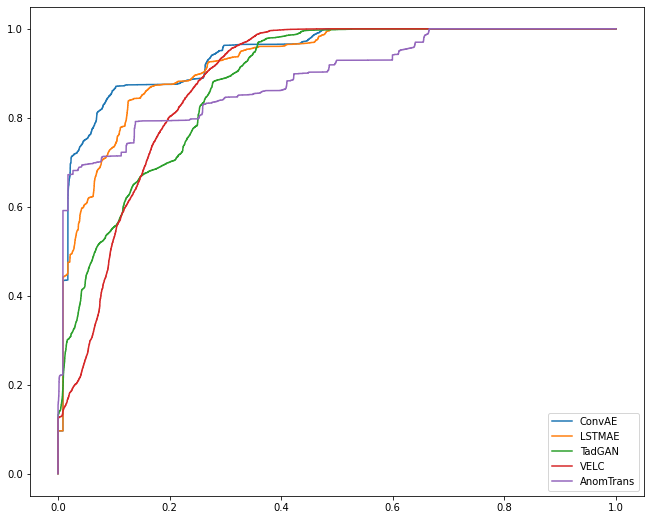

In [8]:
plot_roc_curve(m_1_1_scores, m_1_1_cls, figsize=(11, 9));

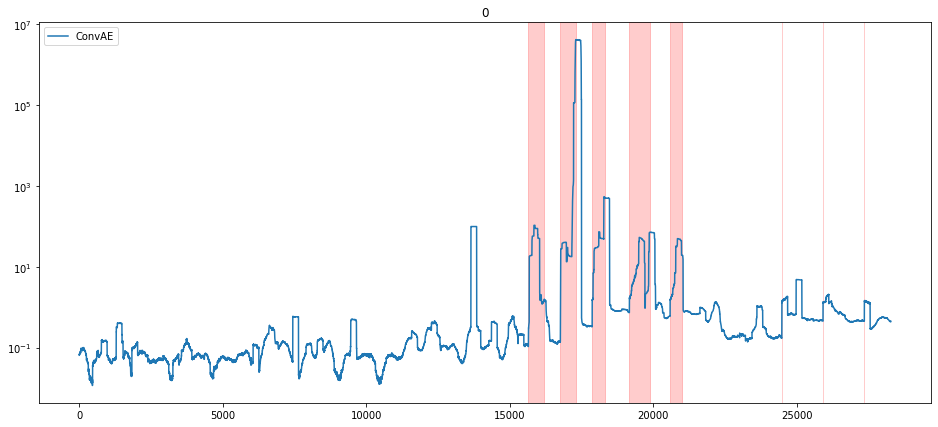

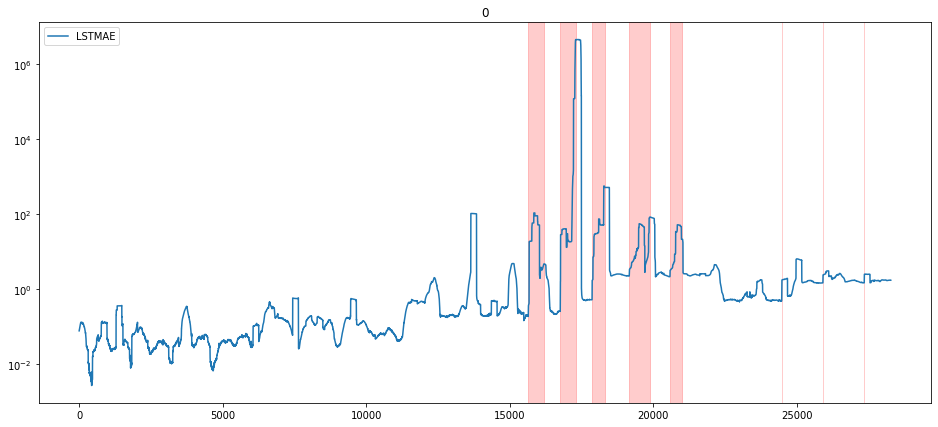

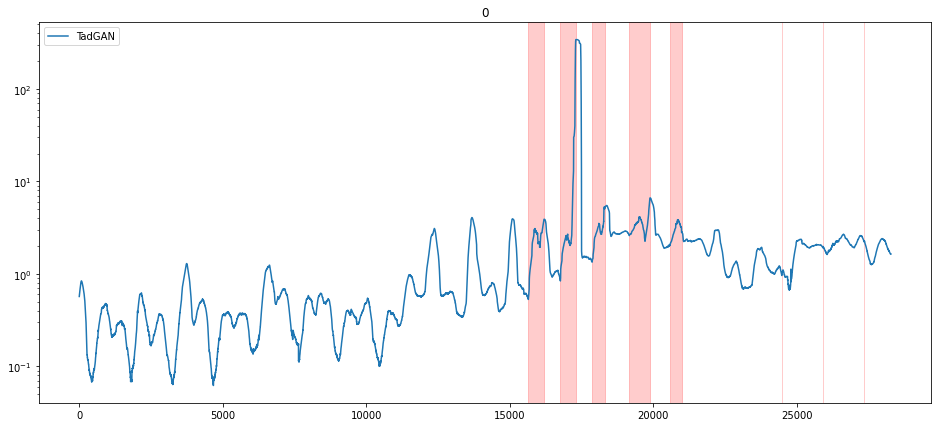

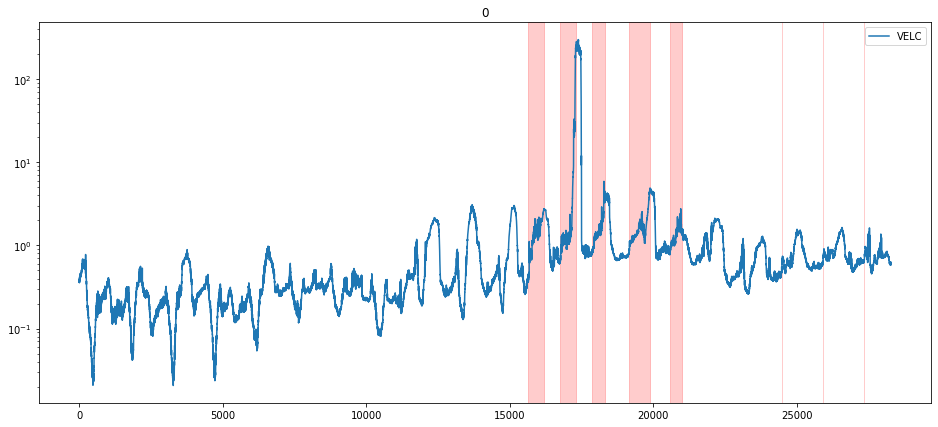

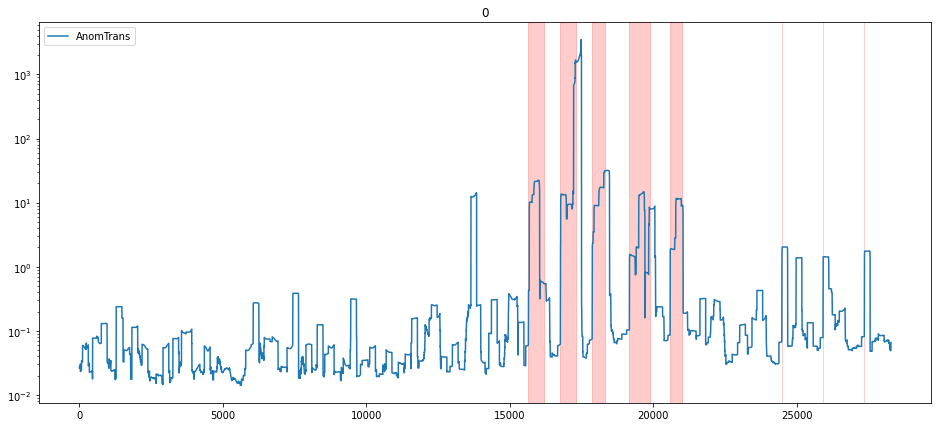

In [9]:
for m_cls in m_1_1_scores:
    plot_dataset(
        {m_cls: m_1_1_scores[m_cls]}, anoms_vrects=anom_ranges,
        figsize=(16, 7), yscale='log'
    );

## Machine-2-1

In [10]:
anom_ranges = get_cls_ids_ranges(
    pd.Index(range(len(m_2_1_point_cls))), m_2_1_point_cls, shift=-199)

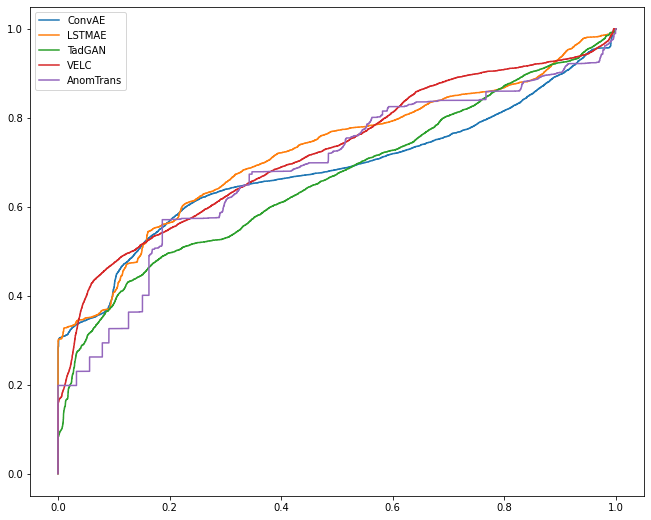

In [11]:
plot_roc_curve(m_2_1_scores, m_2_1_cls, figsize=(11, 9));

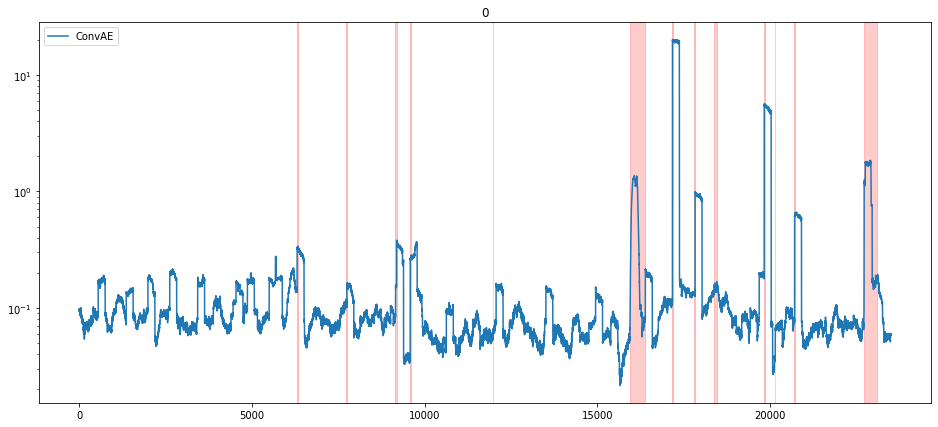

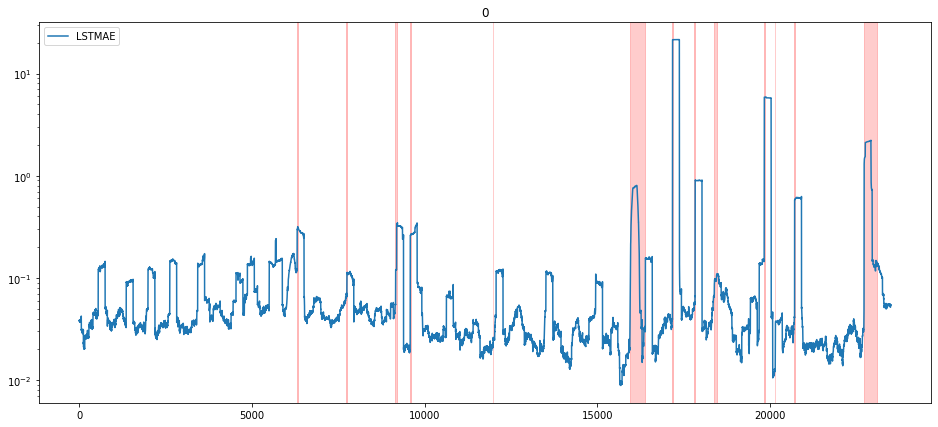

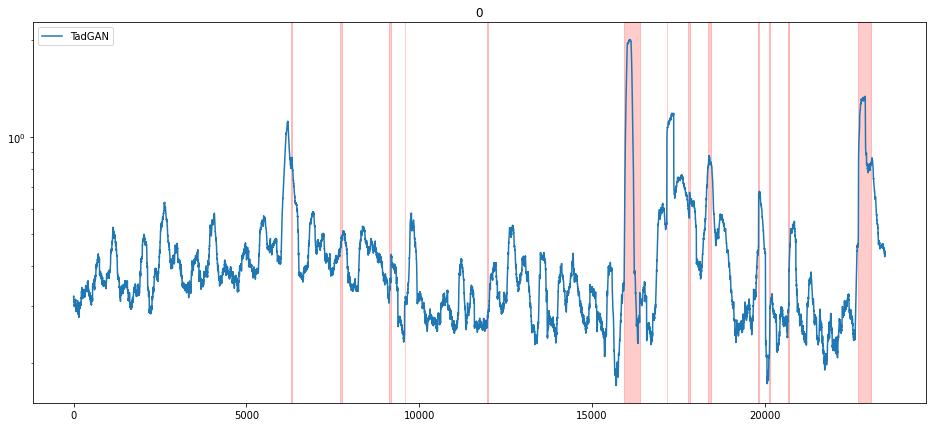

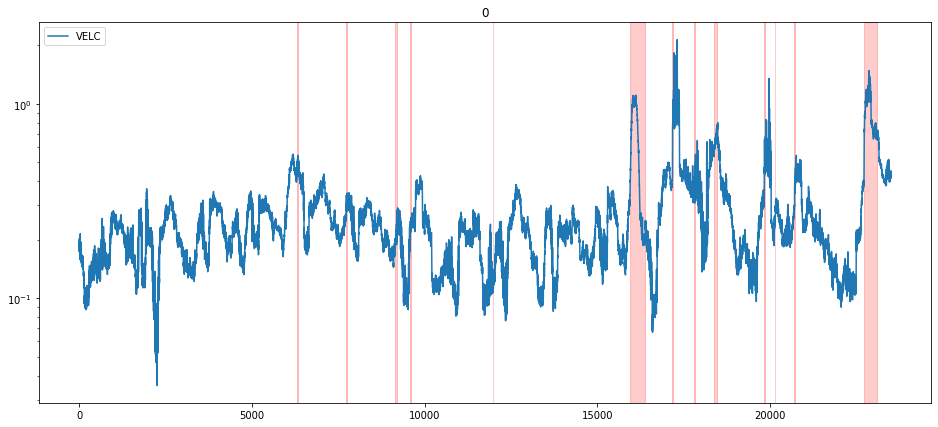

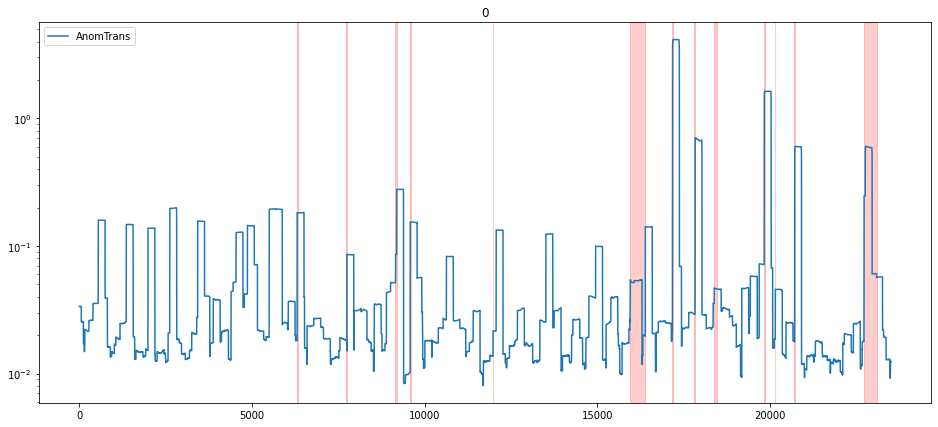

In [12]:
for m_cls in m_2_1_scores:
    plot_dataset(
        {m_cls: m_2_1_scores[m_cls]}, anoms_vrects=anom_ranges, figsize=(16, 7), yscale='log');

## Machine-3-10

In [13]:
anom_ranges = get_cls_ids_ranges(
    pd.Index(range(len(m_3_10_point_cls))), m_3_10_point_cls, shift=-199)

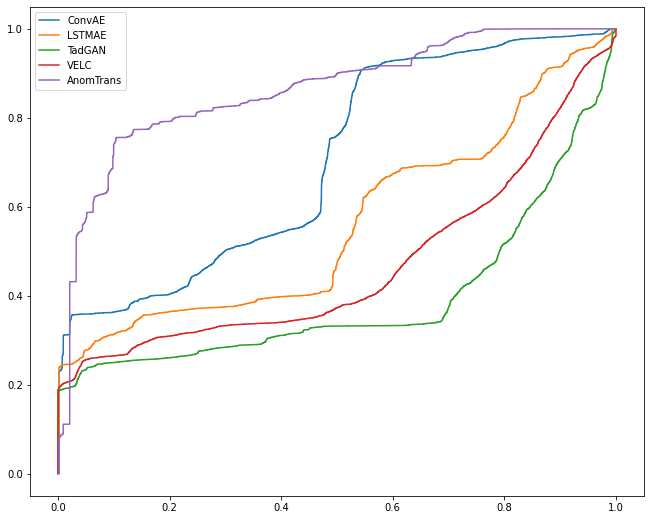

In [14]:
plot_roc_curve(m_3_10_scores, m_3_10_cls, figsize=(11, 9));

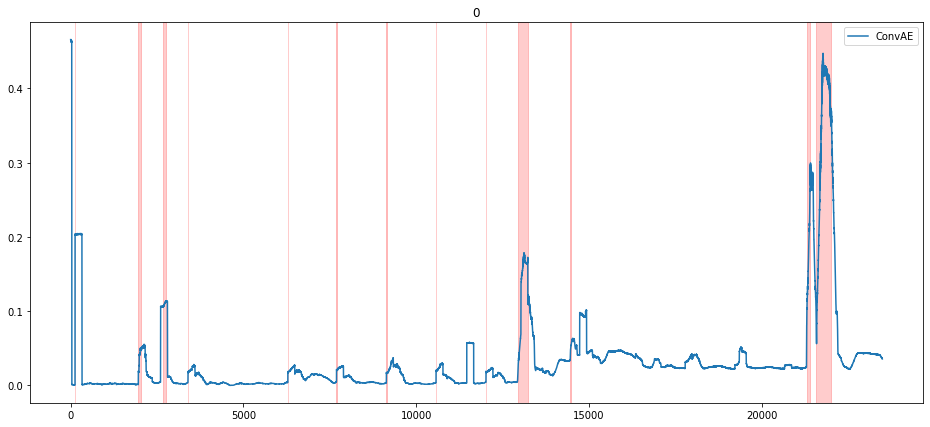

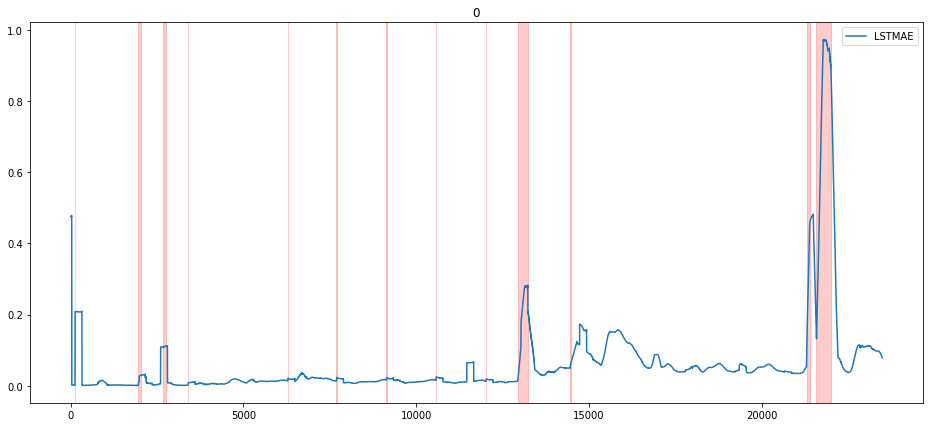

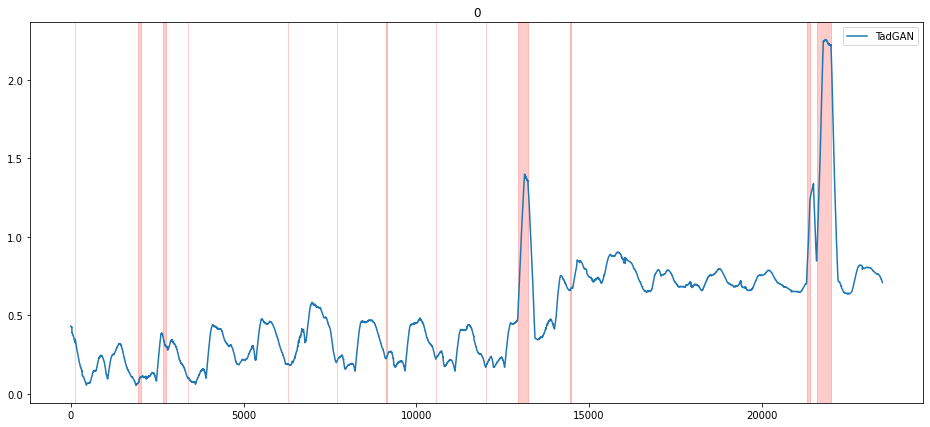

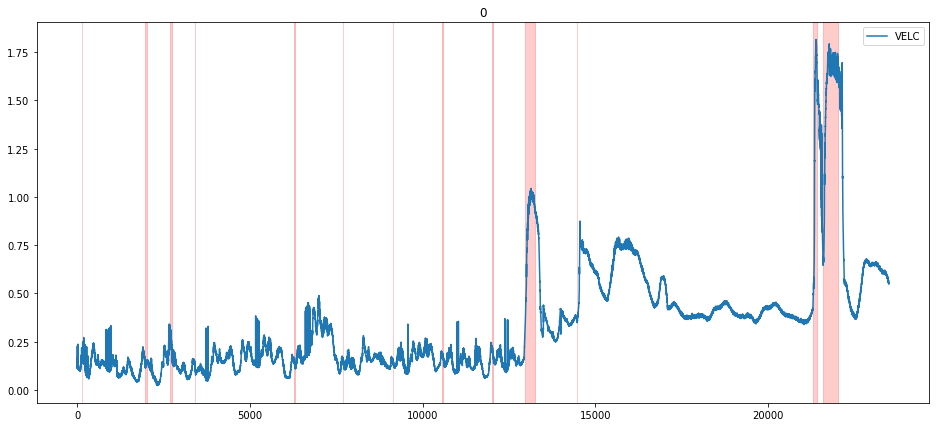

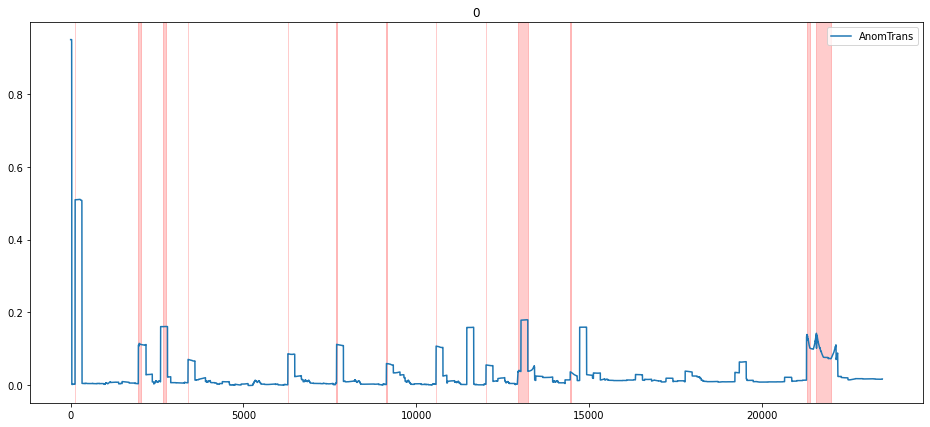

In [15]:
for m_cls in m_3_10_scores:
    plot_dataset(
        {m_cls: m_3_10_scores[m_cls]}, anoms_vrects=anom_ranges, figsize=(16, 7));

# Logistic regression thresholds

In [16]:
load_selected_lr_results(models_1_1_info, 'machine-1-1')

,f1.0-score,f0.5-score
ConvAE_ws200_nk20_ks5_es50,0.725244,0.768140
LSTMAE_h100_z50_l2,0.725448,0.767960
TadGAN_h50_l1_z10,0.633944,0.583983
VELC_h100_l2_z50_N50_th0.0,0.658689,0.608684
AnomTrans_l2_d128_lambda3,0.725391,0.760269


In [17]:
load_selected_lr_results(models_1_1_info, 'machine-1-1')

,f1.0-score,f0.5-score
ConvAE_ws200_nk20_ks5_es50,0.725244,0.768140
LSTMAE_h100_z50_l2,0.725448,0.767960
TadGAN_h50_l1_z10,0.633944,0.583983
VELC_h100_l2_z50_N50_th0.0,0.658689,0.608684
AnomTrans_l2_d128_lambda3,0.725391,0.760269


In [18]:
load_selected_lr_results(models_2_1_info, 'machine-2-1')

,f1.0-score,f0.5-score
ConvAE_ws200_nk20_ks5_es50,0.644534,0.663285
LSTMAE_h50_z10_l1,0.644761,0.663447
TadGAN_h50_l1_z10,0.478096,0.562168
VELC_h100_l2_z50_N50_th0.025,0.650759,0.638356
AnomTrans_l3_d512_lambda10,0.523202,0.622319


In [19]:
load_selected_lr_results(models_2_1_info, 'machine-2-1')

,f1.0-score,f0.5-score
ConvAE_ws200_nk20_ks5_es50,0.644534,0.663285
LSTMAE_h50_z10_l1,0.644761,0.663447
TadGAN_h50_l1_z10,0.478096,0.562168
VELC_h100_l2_z50_N50_th0.025,0.650759,0.638356
AnomTrans_l3_d512_lambda10,0.523202,0.622319


In [20]:
load_selected_lr_results(models_3_10_info, 'machine-3-10')

,f1.0-score,f0.5-score
ConvAE_ws200_nk20_ks5_es50,0.529269,0.632367
LSTMAE_h50_z10_l1,0.411119,0.586124
TadGAN_h50_l1_z10,0.000000,0.000000
VELC_h100_l2_z50_N50_th0.025,0.290985,0.484795
AnomTrans_l2_d128_lambda3,0.664692,0.649745


In [21]:
load_selected_lr_results(models_3_10_info, 'machine-3-10')

,f1.0-score,f0.5-score
ConvAE_ws200_nk20_ks5_es50,0.529269,0.632367
LSTMAE_h50_z10_l1,0.411119,0.586124
TadGAN_h50_l1_z10,0.000000,0.000000
VELC_h100_l2_z50_N50_th0.025,0.290985,0.484795
AnomTrans_l2_d128_lambda3,0.664692,0.649745


In [22]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(
    m_3_10_scores['VELC'], m_3_10_cls)
pred_cls = lr.predict(m_3_10_scores['VELC'])
pred_cls = adjust_point_cls_with_window(
    pred_cls, 200, return_point_cls=True)

fbeta_score(m_3_10_cls, pred_cls, beta=1), fbeta_score(m_3_10_cls, pred_cls, beta=0.5)

(0.2909847434119279, 0.48479526758480457)

In [7]:
def load_best_ws_sth(ds_name: str, m_name: str, exp_date: str):
    # ds_name = 'machine-1-1'
    # for m_name, exp_date in models_1_1_info.items():
        # if m_cls not in m_name:
        #     continue
    path = scores_dirpath_temp.substitute(
        ds_name=ds_name, m_name=m_name, exp_date=exp_date
    ) + 'std_th_exp.csv'
    df = load_th_exp(path)
    df = df.loc[df.groupby(['ws'])['f1.0-score'].idxmax()]
    return df

def lr_predict(a_scores: np.ndarray, true_cls: np.ndarray, model_ws: int = 200):
    lr = LogisticRegression().fit(
        a_scores, true_cls)
    pred_cls = lr.predict(a_scores)
    pred_cls = adjust_point_cls_with_window(
        pred_cls, model_ws, return_point_cls=True)
    return pred_cls

def calculate_mstdd_scores(
    a_scores: np.ndarray, true_point_cls: np.ndarray,
    model_ws: int = 200, ths: List[float] = None,
    ws_list: List[int] = [50, 100, 200, 300, 400, 500],
    m_name: str = 'AnomTrans'
    # range_frac: float = 0.1, n_ths: int = 100,
):
    res = []
    for i, ws in enumerate(tqdm(ws_list)):
        mstdd = get_std(a_scores[m_name], ws, na='drop')
        mstdd = get_diff(mstdd).to_numpy()

        ws_true_cls = adjust_point_cls_with_window(
            true_point_cls, model_ws + ws - 1, return_point_cls=False
        )
        # prop = np.where(ws_true_cls == 1)[0].shape[0] / ws_true_cls.shape[0]
        # lr = LogisticRegression(class_weight={0: prop, 1: 1-prop}).fit(
        #     mstdd, ws_true_cls)
        # ws_pred_cls = lr.predict(mstdd)
        # ths = np.linspace(-lr.intercept_/2, -lr.intercept_*2, 40)

        # fpr, tpr, roc_ths = roc_curve(ws_true_cls, mstdd)
        # g_means = np.sqrt(tpr*(1-fpr))
        # id_max = g_means.argmax()
        # shift = int(len(ths)*range_frac)
        # roc_ths = ths[id_max-3*shift:id_max-shift]
        # step = max(1, int(len(roc_ths)/n_ths))
        # roc_ths = ths[id_max-3*shift:id_max-shift:step]
        # print(f'{i}/{len(ws_list)}')
        # print(f'ws: {ws}\tindex_range: {id_max-3*shift}-{id_max-shift}\tvals_range: {ths[id_max-shift]}-{ths[id_max-3*shift]}\tstep: {step}')

        # ths = np.linspace(ths[id_max]/5, ths[id_max]*5, 100)
        best_f1 = [-1, -1, -1]
        best_f05 = [-1, -1, -1]
        for th in ths:
            ws_pred_cls = np.array([int(val > th) for val in mstdd])
            ws_pred_cls = adjust_point_cls_with_window(
                ws_pred_cls, ws + model_ws - 1, return_point_cls=True
            )
            new_f1 = fbeta_score(ws_true_cls, ws_pred_cls, beta=1)
            new_f05 = fbeta_score(ws_true_cls, ws_pred_cls, beta=0.5)
            if best_f1[1] < new_f1:
                best_f1 = [th, new_f1, new_f05]
            if best_f05[2] < new_f05:
                best_f05 = [th, new_f1, new_f05]
        res += [[ws] + best_f1, [ws] + best_f05]
    df = pd.DataFrame(res, columns=['ws', 'th', 'f1.0-score', 'f0.5-score'])
    return df

def get_a_score_sth_score_comparison(
    ds_name: str, m_name: str, exp_date: str
):
    m_ws_scores = get_ws_scores(
        m_1_1_cls,
        lr_predict(
            m_1_1_scores['AnomTrans'],
            m_1_1_cls))
    m_ws_scores.columns = ['']
    m_sth_scores = load_best_ws_sth(
        ds_name, m_name, exp_date)
    m_ws_scores, m_sth_scores

# Comparing AnomTrans with MSTDD

## Machine 1-1

### AnomTrans a_score

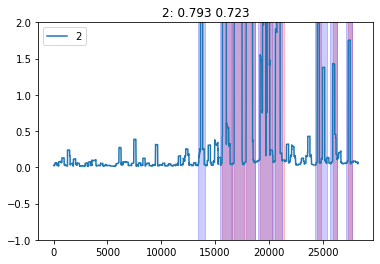

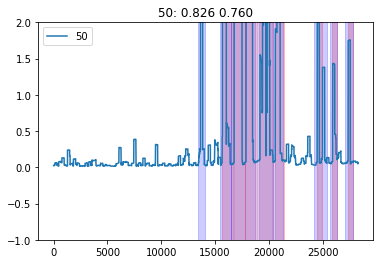

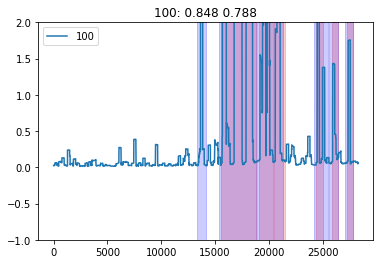

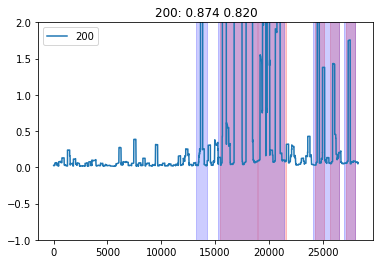

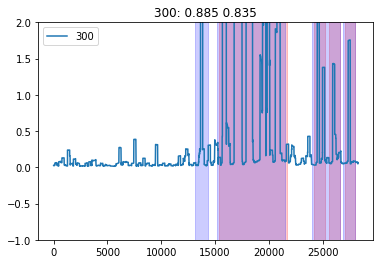

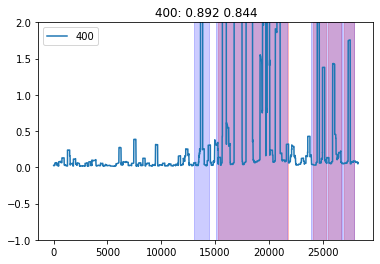

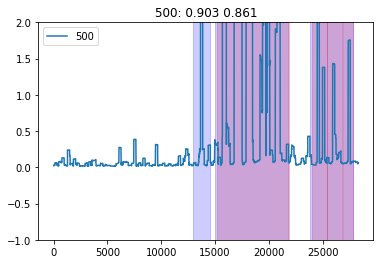

In [93]:
ws_list = [2, 50, 100, 200, 300, 400, 500]
tmp_ranges = get_cls_ids_ranges(pd.Index(range(len(m_1_1_cls))), m_1_1_cls)

model_ws = 200
at_1_1_scores = {}
th = 0.5

for ws in ws_list:
    tmp_m1_1_ws_cls = adjust_point_cls_with_window(m_1_1_cls, ws, return_point_cls=False)
    tmp_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(tmp_m1_1_ws_cls))), tmp_m1_1_ws_cls)
    
    pred_ws_cls = np.array(m_1_1_scores['AnomTrans'] > th, dtype=int).reshape(-1)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, model_ws, return_point_cls=True)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, ws, return_point_cls=False)
    pred_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(pred_ws_cls))), pred_ws_cls)
    
    f1 = fbeta_score(tmp_m1_1_ws_cls, pred_ws_cls, beta=1)
    f05 = fbeta_score(tmp_m1_1_ws_cls, pred_ws_cls, beta=0.5)
    title = f'{ws}: %.3f %.3f' % (f1, f05)
    at_1_1_scores[ws] = [ws, th, f1, f05]
    
    plot_dataset(
        {ws: m_1_1_scores['AnomTrans']}, anoms_vrects=tmp_ws_ranges, pred_anoms_vrects=pred_ws_ranges,
        y_lims=(-1, 2), figsize=(6, 4), titles=[title]);

### MSTDD

In [113]:
def get_diff(stat: pd.DataFrame, na='fill'):
    res = stat.diff()
    if na == 'fill':
        res = res.fillna(0)
    elif na == 'drop':
        res = res.dropna()
    res.name = stat.name + '_diff'
    return res

In [126]:
np.where((tmp_m1_1_ws_cls!=1) & (tmp_m1_1_ws_cls!=0))[0], np.where((pred_ws_cls!=1) & (pred_ws_cls!=0))[0]
np.where((pred_ws_cls!=1) & (pred_ws_cls!=0))[0], pred_ws_cls[np.where((pred_ws_cls!=1) & (pred_ws_cls!=0))[0]]

(array([200, 201, 202]), array([nan, nan, nan]))

In [132]:
adjust_point_cls_with_window(m_1_1_cls, ws, return_point_cls=False).shape, m_1_1_cls.shape

((28279,), (28280,))

In [128]:
ws_list = [2, 50, 100, 200, 300, 400, 500]
mstdds = {ws: get_diff(get_std(m_1_1_scores['AnomTrans'], ws, na='drop')) for ws in ws_list}
tmp_ranges = get_cls_ids_ranges(pd.Index(range(len(m_1_1_cls))), m_1_1_cls)

model_ws = 200
at_sth_1_1_scores = {}
ths = [0.3, 0.05, 0.05, 0.03, 0.02, 0.02, 0.01]

for ws, th in zip(ws_list, ths):
    tmp_m1_1_ws_cls = adjust_point_cls_with_window(m_1_1_cls, ws, return_point_cls=False)
    tmp_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(tmp_m1_1_ws_cls))), tmp_m1_1_ws_cls)
    
    pred_ws_cls = np.array(mstdds[ws] > th, dtype=int).reshape(-1)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, model_ws, return_point_cls=True)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, ws, return_point_cls=True)
    pred_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(pred_ws_cls))), pred_ws_cls)

    f1 = fbeta_score(tmp_m1_1_ws_cls, pred_ws_cls, beta=1)
    f05 = fbeta_score(tmp_m1_1_ws_cls, pred_ws_cls, beta=0.5)
    title = f'{ws}: %.3f %.3f' % (f1, f05)
    at_sth_1_1_scores[ws] = [ws, th, f1, f05]
    
    plot_dataset(
        {ws: mstdds[ws]}, anoms_vrects=tmp_ws_ranges, pred_anoms_vrects=pred_ws_ranges,
        y_lims=(-1, 2), figsize=(6, 4), titles=[title]);

ValueError: Found input variables with inconsistent numbers of samples: [28279, 28278]

### Comparison

In [67]:
at_1_1_scores_df = pd.DataFrame.from_dict(
    at_1_1_scores, orient='index', columns=['ws','th','f1.0-score','f0.5-score']).reset_index(drop=True)
at_sth_1_1_scores_df = pd.DataFrame.from_dict(
    at_sth_1_1_scores, orient='index', columns=['ws','th','f1.0-score','f0.5-score']).reset_index(drop=True)

at_1_1_scores_df.join(at_sth_1_1_scores_df, lsuffix='_at', rsuffix='_std')

,ws_at,th_at,f1.0-score_at,f0.5-score_at,ws_std,th_std,f1.0-score_std,f0.5-score_std
0,2,0.5,0.792853,0.723059,2,0.5,0.773368,0.710359
1,50,0.5,0.825590,0.759504,50,0.5,0.798012,0.731713
2,100,0.5,0.848202,0.788094,100,0.5,0.823031,0.753820
3,200,0.5,0.873919,0.820083,200,0.5,0.838300,0.771866
4,300,0.5,0.885238,0.835413,300,0.5,0.839200,0.771466
5,400,0.5,0.891563,0.844000,400,0.5,0.844014,0.777605
6,500,0.5,0.903489,0.860753,500,0.5,0.850553,0.786170


## Machine 2-1

### AnomTrans a_score

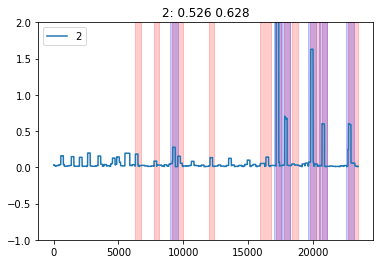

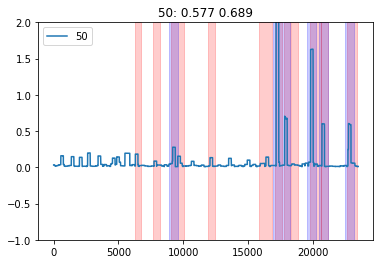

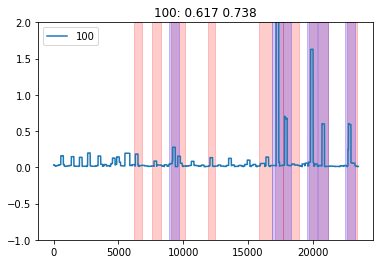

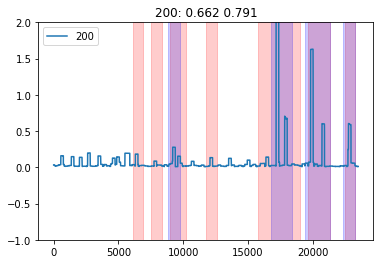

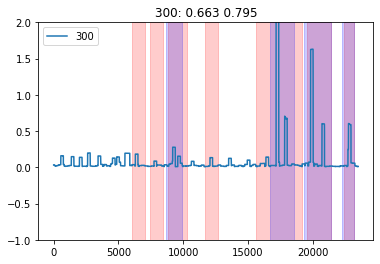

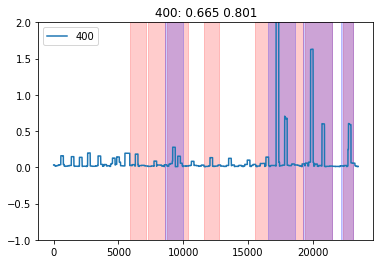

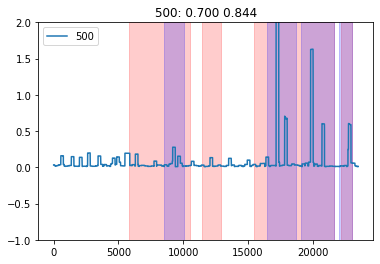

In [68]:
ws_list = [2, 50, 100, 200, 300, 400, 500]
tmp_ranges = get_cls_ids_ranges(pd.Index(range(len(m_2_1_cls))), m_2_1_cls)

model_ws = 200
at_2_1_scores = {}
th = 0.25

for ws in ws_list:
    tmp_m2_1_ws_cls = adjust_point_cls_with_window(m_2_1_cls, ws, return_point_cls=False)
    tmp_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(tmp_m2_1_ws_cls))), tmp_m2_1_ws_cls)
    
    pred_ws_cls = np.array(m_2_1_scores['AnomTrans'] > th, dtype=int).reshape(-1)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, model_ws, return_point_cls=True)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, ws, return_point_cls=False)
    pred_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(pred_ws_cls))), pred_ws_cls)
    
    f1 = fbeta_score(tmp_m2_1_ws_cls, pred_ws_cls, beta=1)
    f05 = fbeta_score(tmp_m2_1_ws_cls, pred_ws_cls, beta=0.5)
    title = f'{ws}: %.3f %.3f' % (f1, f05)
    at_2_1_scores[ws] = [ws, th, f1, f05]
    
    plot_dataset(
        {ws: m_2_1_scores['AnomTrans']}, anoms_vrects=tmp_ws_ranges, pred_anoms_vrects=pred_ws_ranges,
        y_lims=(-1, 2), figsize=(6, 4), titles=[title]);

### MSTDD

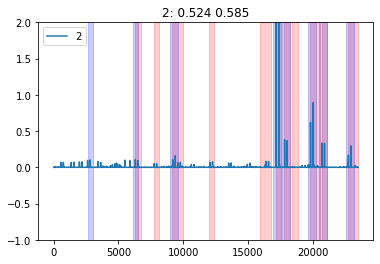

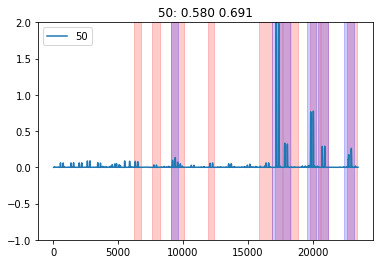

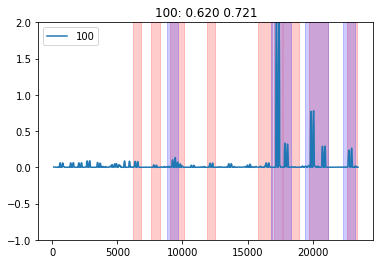

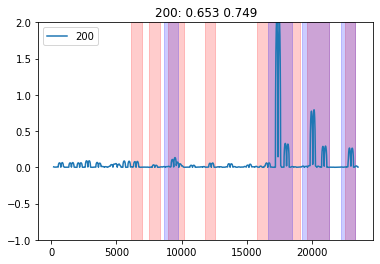

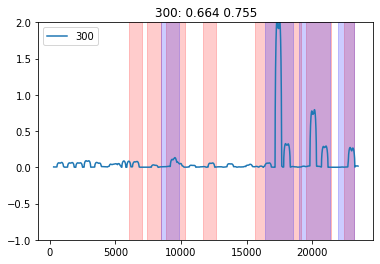

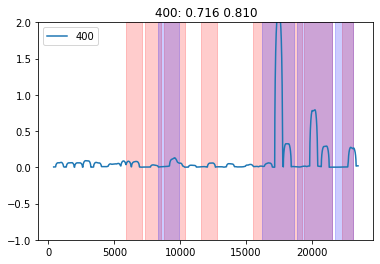

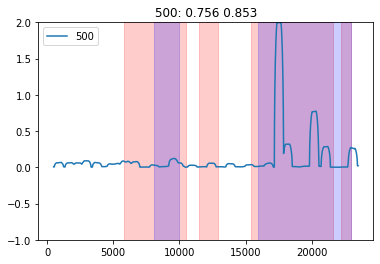

In [69]:
ws_list = [2, 50, 100, 200, 300, 400, 500]
mstdds = {ws: get_diff(get_std(m_2_1_scores['AnomTrans'], ws, na='drop')) for ws in ws_list}
tmp_ranges = get_cls_ids_ranges(pd.Index(range(len(m_2_1_cls))), m_2_1_cls)

model_ws = 200
at_sth_2_1_scores = {}
ths = [0.1] * len(ws_list)

for ws, th in zip(ws_list, ths):
    tmp_m2_1_ws_cls = adjust_point_cls_with_window(m_2_1_cls, ws, return_point_cls=False)
    tmp_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(tmp_m2_1_ws_cls))), tmp_m2_1_ws_cls)
    
    pred_ws_cls = np.array(mstdds[ws] > th, dtype=int).reshape(-1)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, model_ws, return_point_cls=True)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, ws, return_point_cls=True)
    pred_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(pred_ws_cls))), pred_ws_cls)

    f1 = fbeta_score(tmp_m2_1_ws_cls, pred_ws_cls, beta=1)
    f05 = fbeta_score(tmp_m2_1_ws_cls, pred_ws_cls, beta=0.5)
    title = f'{ws}: %.3f %.3f' % (f1, f05)
    at_sth_2_1_scores[ws] = [ws, th, f1, f05]
    
    plot_dataset(
        {ws: mstdds[ws]}, anoms_vrects=tmp_ws_ranges, pred_anoms_vrects=pred_ws_ranges,
        y_lims=(-1, 2), figsize=(6, 4), titles=[title]);

### Comparison

In [70]:
at_2_1_scores_df = pd.DataFrame.from_dict(
    at_2_1_scores, orient='index', columns=['ws','th','f1.0-score','f0.5-score']).reset_index(drop=True)
at_sth_2_1_scores_df = pd.DataFrame.from_dict(
    at_sth_2_1_scores, orient='index', columns=['ws','th','f1.0-score','f0.5-score']).reset_index(drop=True)

at_2_1_scores_df.join(at_sth_2_1_scores_df, lsuffix='_at', rsuffix='_std')

,ws_at,th_at,f1.0-score_at,f0.5-score_at,ws_std,th_std,f1.0-score_std,f0.5-score_std
0,2,0.25,0.525996,0.627721,2,0.1,0.523930,0.584902
1,50,0.25,0.576886,0.689430,50,0.1,0.579921,0.690627
2,100,0.25,0.616856,0.737809,100,0.1,0.620402,0.720578
3,200,0.25,0.662351,0.790681,200,0.1,0.652842,0.749312
4,300,0.25,0.662814,0.795071,300,0.1,0.663713,0.755375
5,400,0.25,0.665339,0.801234,400,0.1,0.716324,0.810232
6,500,0.25,0.699601,0.843938,500,0.1,0.756363,0.853157


## Machine 3-10

### AnomTrans a_score

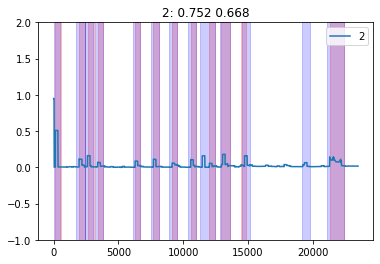

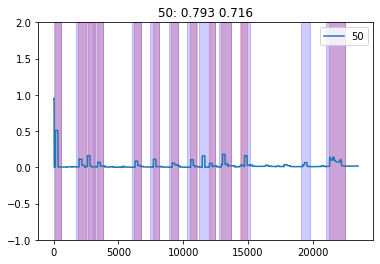

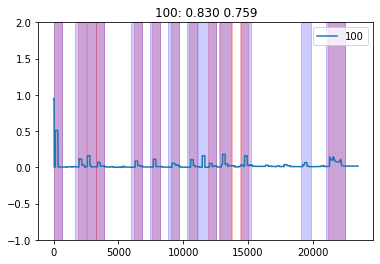

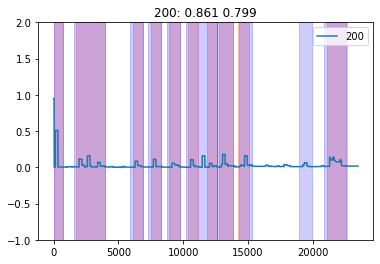

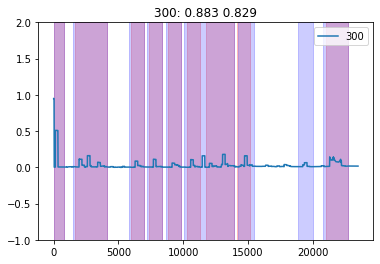

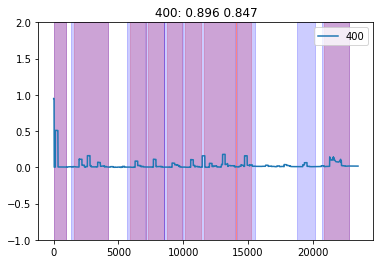

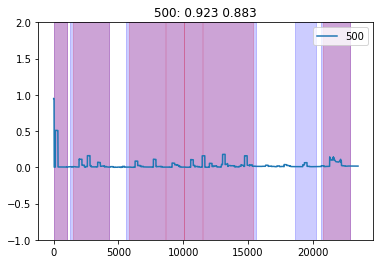

In [71]:
ws_list = [2, 50, 100, 200, 300, 400, 500]
tmp_ranges = get_cls_ids_ranges(pd.Index(range(len(m_3_10_cls))), m_3_10_cls)

model_ws = 200
at_3_10_scores = {}
th = 0.05

for ws in ws_list:
    tmp_m3_10_ws_cls = adjust_point_cls_with_window(m_3_10_cls, ws, return_point_cls=False)
    tmp_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(tmp_m3_10_ws_cls))), tmp_m3_10_ws_cls)
    
    pred_ws_cls = np.array(m_3_10_scores['AnomTrans'] > th, dtype=int).reshape(-1)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, model_ws, return_point_cls=True)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, ws, return_point_cls=False)
    pred_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(pred_ws_cls))), pred_ws_cls)
    
    f1 = fbeta_score(tmp_m3_10_ws_cls, pred_ws_cls, beta=1)
    f05 = fbeta_score(tmp_m3_10_ws_cls, pred_ws_cls, beta=0.5)
    title = f'{ws}: %.3f %.3f' % (f1, f05)
    at_3_10_scores[ws] = [ws, th, f1, f05]
    
    plot_dataset(
        {ws: m_3_10_scores['AnomTrans']}, anoms_vrects=tmp_ws_ranges, pred_anoms_vrects=pred_ws_ranges,
        y_lims=(-1, 2), figsize=(6, 4), titles=[title]);

### MSTDD

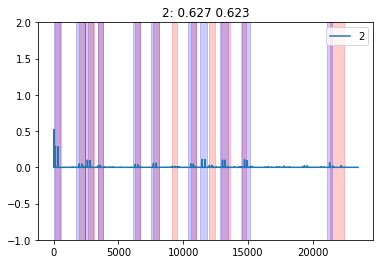

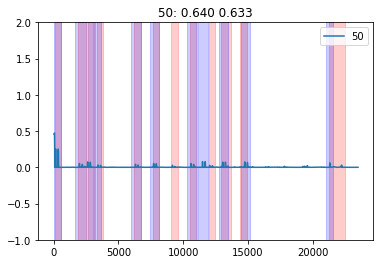

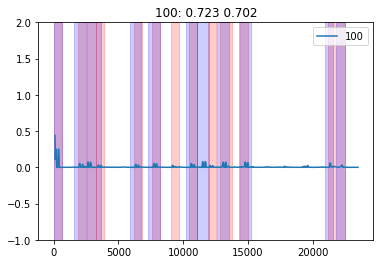

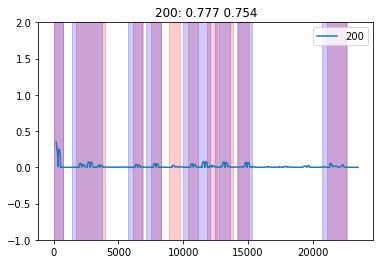

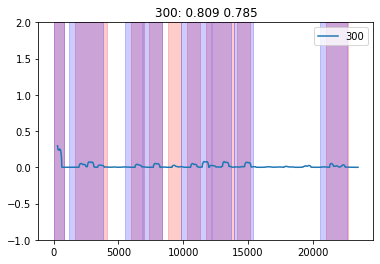

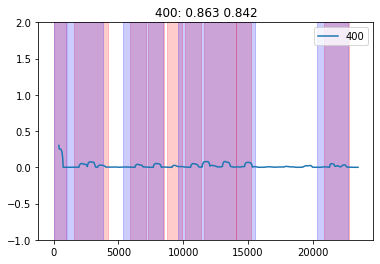

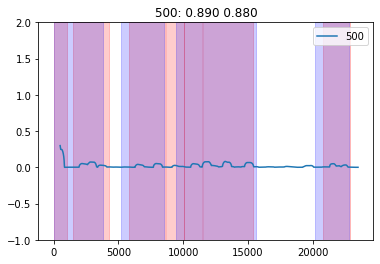

In [72]:
ws_list = [2, 50, 100, 200, 300, 400, 500]
mstdds = {ws: get_diff(get_std(m_3_10_scores['AnomTrans'], ws, na='drop')) for ws in ws_list}
tmp_ranges = get_cls_ids_ranges(pd.Index(range(len(m_3_10_cls))), m_3_10_cls)

model_ws = 200
at_sth_3_10_scores = {}
ths = [0.03] * len(ws_list)

for ws, th in zip(ws_list, ths):
    tmp_m3_10_ws_cls = adjust_point_cls_with_window(m_3_10_cls, ws, return_point_cls=False)
    tmp_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(tmp_m3_10_ws_cls))), tmp_m3_10_ws_cls)
    
    pred_ws_cls = np.array(mstdds[ws] > th, dtype=int).reshape(-1)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, model_ws, return_point_cls=True)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, ws, return_point_cls=True)
    pred_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(pred_ws_cls))), pred_ws_cls)

    f1 = fbeta_score(tmp_m3_10_ws_cls, pred_ws_cls, beta=1)
    f05 = fbeta_score(tmp_m3_10_ws_cls, pred_ws_cls, beta=0.5)
    title = f'{ws}: %.3f %.3f' % (f1, f05)
    at_sth_3_10_scores[ws] = [ws, th, f1, f05]
    
    plot_dataset(
        {ws: mstdds[ws]}, anoms_vrects=tmp_ws_ranges, pred_anoms_vrects=pred_ws_ranges,
        y_lims=(-1, 2), figsize=(6, 4), titles=[title]);

### Comparison

In [73]:
at_3_10_scores_df = pd.DataFrame.from_dict(
    at_3_10_scores, orient='index', columns=['ws','th','f1.0-score','f0.5-score']).reset_index(drop=True)
at_sth_3_10_scores_df = pd.DataFrame.from_dict(
    at_sth_3_10_scores, orient='index', columns=['ws','th','f1.0-score','f0.5-score']).reset_index(drop=True)

at_3_10_scores_df.join(at_sth_3_10_scores_df, lsuffix='_at', rsuffix='_std')

,ws_at,th_at,f1.0-score_at,f0.5-score_at,ws_std,th_std,f1.0-score_std,f0.5-score_std
0,2,0.05,0.751542,0.668004,2,0.03,0.626866,0.622820
1,50,0.05,0.793239,0.716038,50,0.03,0.639688,0.633493
2,100,0.05,0.830170,0.759186,100,0.03,0.723100,0.702027
3,200,0.05,0.860648,0.799207,200,0.03,0.777378,0.753917
4,300,0.05,0.883005,0.829462,300,0.03,0.809489,0.785219
5,400,0.05,0.895912,0.847254,400,0.03,0.863185,0.842111
6,500,0.05,0.923077,0.882716,500,0.03,0.889912,0.880117


# Comparing ConvAE with MSTDD

## Machine 1-1

### ConvAE a_score

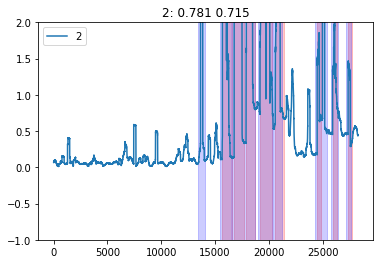

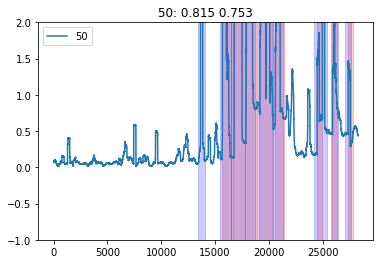

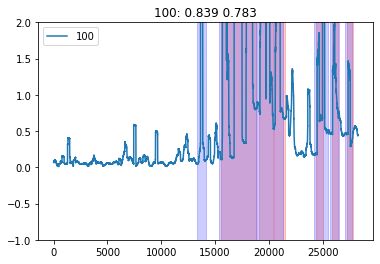

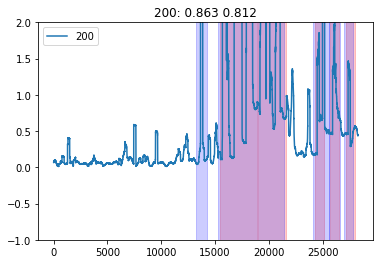

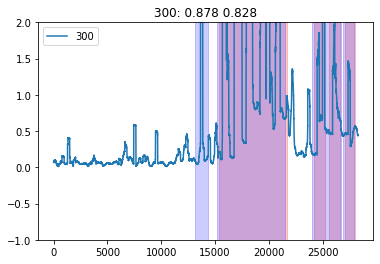

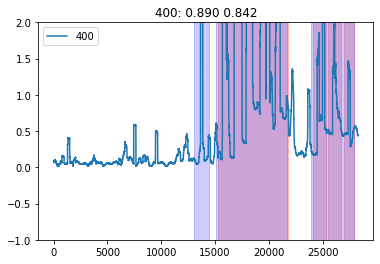

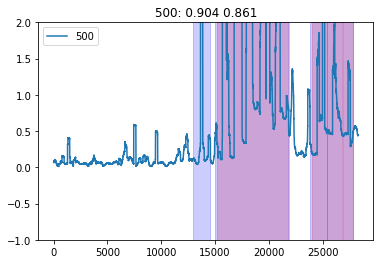

In [77]:
ws_list = [2, 50, 100, 200, 300, 400, 500]
tmp_ranges = get_cls_ids_ranges(pd.Index(range(len(m_1_1_cls))), m_1_1_cls)

model_ws = 200
at_1_1_scores = {}
th = 1.4

for ws in ws_list:
    tmp_m1_1_ws_cls = adjust_point_cls_with_window(m_1_1_cls, ws, return_point_cls=False)
    tmp_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(tmp_m1_1_ws_cls))), tmp_m1_1_ws_cls)
    
    pred_ws_cls = np.array(m_1_1_scores['ConvAE'] > th, dtype=int).reshape(-1)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, model_ws, return_point_cls=True)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, ws, return_point_cls=False)
    pred_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(pred_ws_cls))), pred_ws_cls)
    
    f1 = fbeta_score(tmp_m1_1_ws_cls, pred_ws_cls, beta=1)
    f05 = fbeta_score(tmp_m1_1_ws_cls, pred_ws_cls, beta=0.5)
    title = f'{ws}: %.3f %.3f' % (f1, f05)
    at_1_1_scores[ws] = [ws, th, f1, f05]
    
    plot_dataset(
        {ws: m_1_1_scores['ConvAE']}, anoms_vrects=tmp_ws_ranges, pred_anoms_vrects=pred_ws_ranges,
        y_lims=(-1, 2), figsize=(6, 4), titles=[title]);

### MSTDD

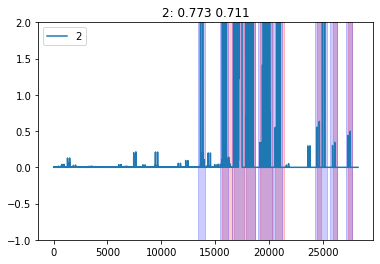

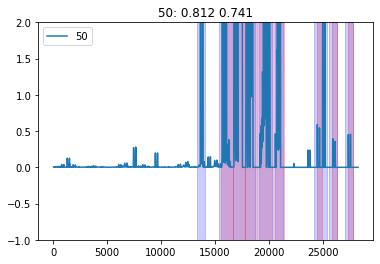

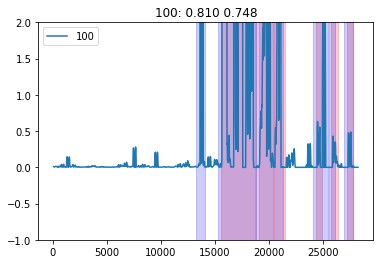

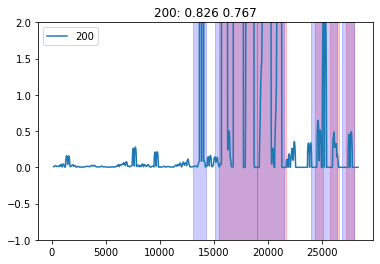

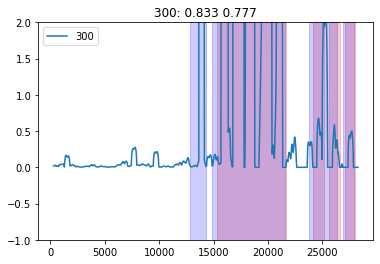

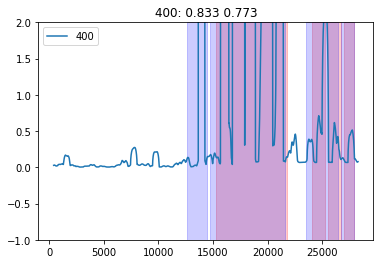

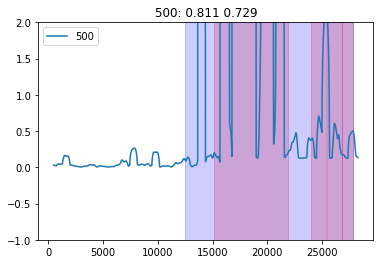

In [90]:
ws_list = [2, 50, 100, 200, 300, 400, 500]
mstdds = {ws: get_diff(get_std(m_1_1_scores['ConvAE'], ws, na='drop')) for ws in ws_list}
tmp_ranges = get_cls_ids_ranges(pd.Index(range(len(m_1_1_cls))), m_1_1_cls)

model_ws = 200
at_sth_1_1_scores = {}
ths = [0.3, 0.3, 0.4, 0.4, 0.5, 0.5, 0.4]

for ws, th in zip(ws_list, ths):
    tmp_m1_1_ws_cls = adjust_point_cls_with_window(m_1_1_cls, ws, return_point_cls=False)
    tmp_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(tmp_m1_1_ws_cls))), tmp_m1_1_ws_cls)
    
    pred_ws_cls = np.array(mstdds[ws] > th, dtype=int).reshape(-1)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, model_ws, return_point_cls=True)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, ws, return_point_cls=True)
    pred_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(pred_ws_cls))), pred_ws_cls)

    f1 = fbeta_score(tmp_m1_1_ws_cls, pred_ws_cls, beta=1)
    f05 = fbeta_score(tmp_m1_1_ws_cls, pred_ws_cls, beta=0.5)
    title = f'{ws}: %.3f %.3f' % (f1, f05)
    at_sth_1_1_scores[ws] = [ws, th, f1, f05]
    
    plot_dataset(
        {ws: mstdds[ws]}, anoms_vrects=tmp_ws_ranges, pred_anoms_vrects=pred_ws_ranges,
        y_lims=(-1, 2), figsize=(6, 4), titles=[title]);

### Comparison

In [91]:
at_1_1_scores_df = pd.DataFrame.from_dict(
    at_1_1_scores, orient='index', columns=['ws','th','f1.0-score','f0.5-score']).reset_index(drop=True)
at_sth_1_1_scores_df = pd.DataFrame.from_dict(
    at_sth_1_1_scores, orient='index', columns=['ws','th','f1.0-score','f0.5-score']).reset_index(drop=True)

at_1_1_scores_df.join(at_sth_1_1_scores_df, lsuffix='_at', rsuffix='_std')

,ws_at,th_at,f1.0-score_at,f0.5-score_at,ws_std,th_std,f1.0-score_std,f0.5-score_std
0,2,1.4,0.781059,0.715395,2,0.3,0.773480,0.710510
1,50,1.4,0.815246,0.753001,50,0.3,0.811762,0.740980
2,100,1.4,0.839074,0.782512,100,0.4,0.810219,0.747594
3,200,1.4,0.863306,0.811602,200,0.4,0.826439,0.766535
4,300,1.4,0.878094,0.827995,300,0.5,0.832993,0.777183
5,400,1.4,0.889938,0.841628,400,0.5,0.832966,0.772660
6,500,1.4,0.903528,0.860810,500,0.4,0.811257,0.728731


## Machine 2-1

### ConvAE a_score

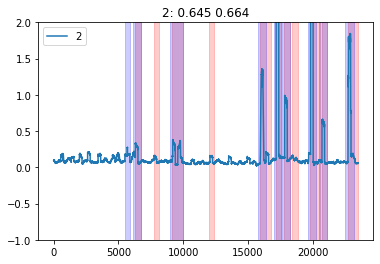

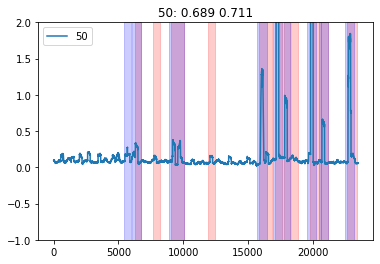

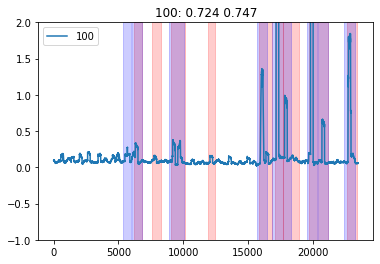

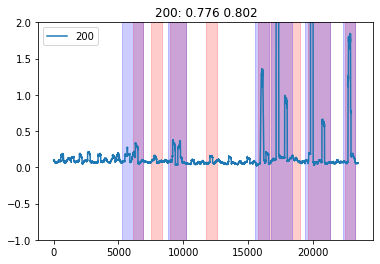

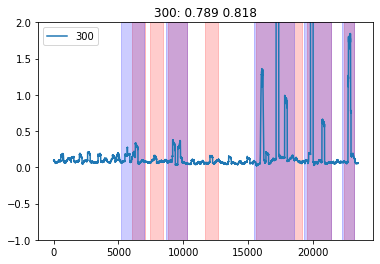

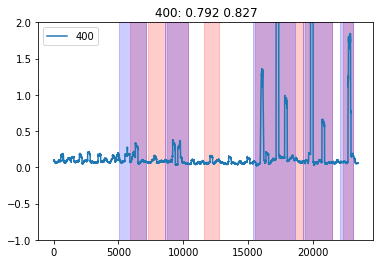

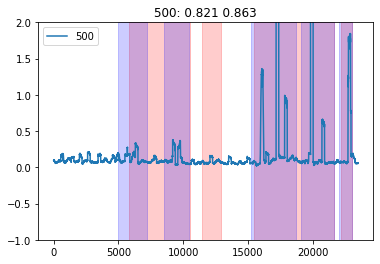

In [92]:
ws_list = [2, 50, 100, 200, 300, 400, 500]
tmp_ranges = get_cls_ids_ranges(pd.Index(range(len(m_2_1_cls))), m_2_1_cls)

model_ws = 200
at_2_1_scores = {}
th = 0.25

for ws in ws_list:
    tmp_m2_1_ws_cls = adjust_point_cls_with_window(m_2_1_cls, ws, return_point_cls=False)
    tmp_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(tmp_m2_1_ws_cls))), tmp_m2_1_ws_cls)
    
    pred_ws_cls = np.array(m_2_1_scores['ConvAE'] > th, dtype=int).reshape(-1)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, model_ws, return_point_cls=True)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, ws, return_point_cls=False)
    pred_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(pred_ws_cls))), pred_ws_cls)
    
    f1 = fbeta_score(tmp_m2_1_ws_cls, pred_ws_cls, beta=1)
    f05 = fbeta_score(tmp_m2_1_ws_cls, pred_ws_cls, beta=0.5)
    title = f'{ws}: %.3f %.3f' % (f1, f05)
    at_2_1_scores[ws] = [ws, th, f1, f05]
    
    plot_dataset(
        {ws: m_2_1_scores['ConvAE']}, anoms_vrects=tmp_ws_ranges, pred_anoms_vrects=pred_ws_ranges,
        y_lims=(-1, 2), figsize=(6, 4), titles=[title]);

### MSTDD

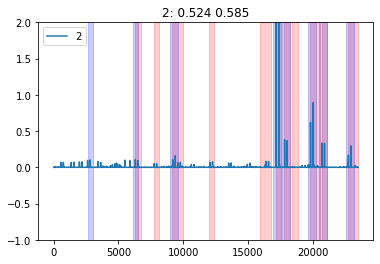

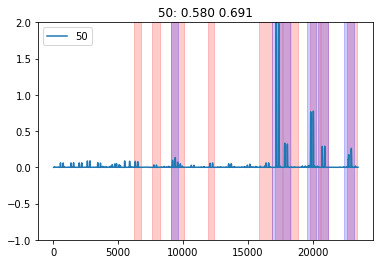

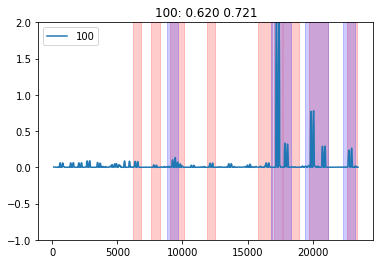

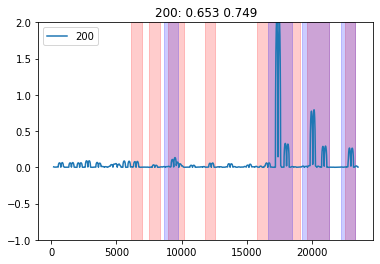

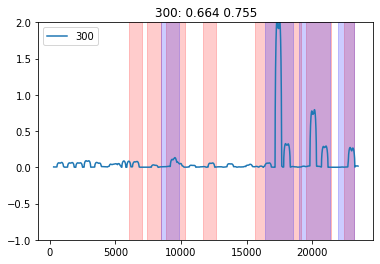

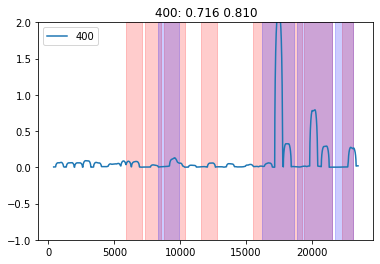

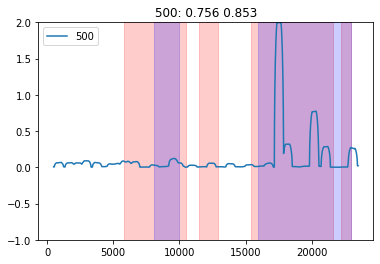

In [83]:
ws_list = [2, 50, 100, 200, 300, 400, 500]
mstdds = {ws: get_diff(get_std(m_2_1_scores['AnomTrans'], ws, na='drop')) for ws in ws_list}
tmp_ranges = get_cls_ids_ranges(pd.Index(range(len(m_2_1_cls))), m_2_1_cls)

model_ws = 200
at_sth_2_1_scores = {}
ths = [0.1] * len(ws_list)

for ws, th in zip(ws_list, ths):
    tmp_m2_1_ws_cls = adjust_point_cls_with_window(m_2_1_cls, ws, return_point_cls=False)
    tmp_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(tmp_m2_1_ws_cls))), tmp_m2_1_ws_cls)
    
    pred_ws_cls = np.array(mstdds[ws] > th, dtype=int).reshape(-1)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, model_ws, return_point_cls=True)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, ws, return_point_cls=True)
    pred_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(pred_ws_cls))), pred_ws_cls)

    f1 = fbeta_score(tmp_m2_1_ws_cls, pred_ws_cls, beta=1)
    f05 = fbeta_score(tmp_m2_1_ws_cls, pred_ws_cls, beta=0.5)
    title = f'{ws}: %.3f %.3f' % (f1, f05)
    at_sth_2_1_scores[ws] = [ws, th, f1, f05]
    
    plot_dataset(
        {ws: mstdds[ws]}, anoms_vrects=tmp_ws_ranges, pred_anoms_vrects=pred_ws_ranges,
        y_lims=(-1, 2), figsize=(6, 4), titles=[title]);

### Comparison

In [84]:
at_2_1_scores_df = pd.DataFrame.from_dict(
    at_2_1_scores, orient='index', columns=['ws','th','f1.0-score','f0.5-score']).reset_index(drop=True)
at_sth_2_1_scores_df = pd.DataFrame.from_dict(
    at_sth_2_1_scores, orient='index', columns=['ws','th','f1.0-score','f0.5-score']).reset_index(drop=True)

at_2_1_scores_df.join(at_sth_2_1_scores_df, lsuffix='_at', rsuffix='_std')

,ws_at,th_at,f1.0-score_at,f0.5-score_at,ws_std,th_std,f1.0-score_std,f0.5-score_std
0,2,0.25,0.645269,0.664189,2,0.1,0.523930,0.584902
1,50,0.25,0.688782,0.710683,50,0.1,0.579921,0.690627
2,100,0.25,0.724223,0.747460,100,0.1,0.620402,0.720578
3,200,0.25,0.776395,0.801805,200,0.1,0.652842,0.749312
4,300,0.25,0.788878,0.817636,300,0.1,0.663713,0.755375
5,400,0.25,0.791676,0.827073,400,0.1,0.716324,0.810232
6,500,0.25,0.821448,0.862683,500,0.1,0.756363,0.853157


## Machine 3-10

### ConvAE a_score

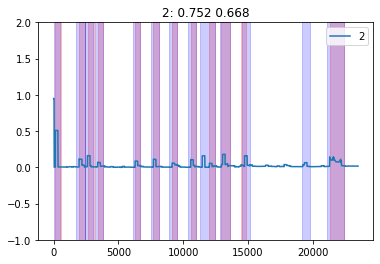

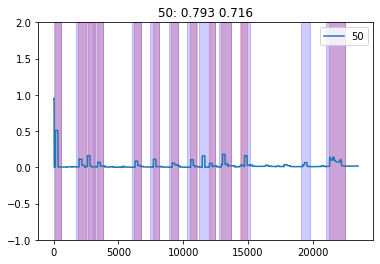

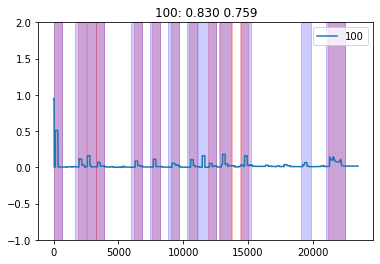

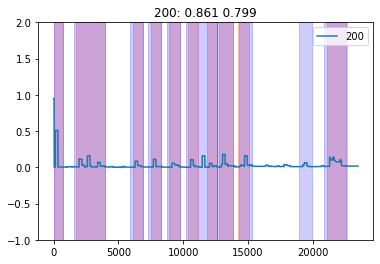

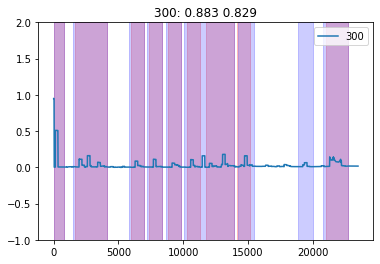

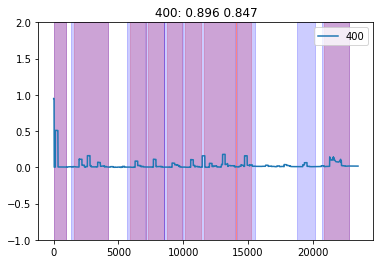

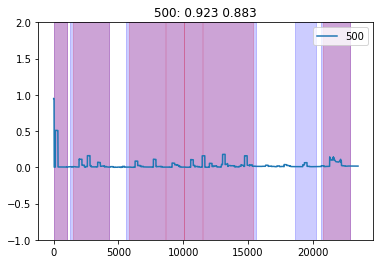

In [85]:
ws_list = [2, 50, 100, 200, 300, 400, 500]
tmp_ranges = get_cls_ids_ranges(pd.Index(range(len(m_3_10_cls))), m_3_10_cls)

model_ws = 200
at_3_10_scores = {}
th = 0.05

for ws in ws_list:
    tmp_m3_10_ws_cls = adjust_point_cls_with_window(m_3_10_cls, ws, return_point_cls=False)
    tmp_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(tmp_m3_10_ws_cls))), tmp_m3_10_ws_cls)
    
    pred_ws_cls = np.array(m_3_10_scores['AnomTrans'] > th, dtype=int).reshape(-1)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, model_ws, return_point_cls=True)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, ws, return_point_cls=False)
    pred_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(pred_ws_cls))), pred_ws_cls)
    
    f1 = fbeta_score(tmp_m3_10_ws_cls, pred_ws_cls, beta=1)
    f05 = fbeta_score(tmp_m3_10_ws_cls, pred_ws_cls, beta=0.5)
    title = f'{ws}: %.3f %.3f' % (f1, f05)
    at_3_10_scores[ws] = [ws, th, f1, f05]
    
    plot_dataset(
        {ws: m_3_10_scores['AnomTrans']}, anoms_vrects=tmp_ws_ranges, pred_anoms_vrects=pred_ws_ranges,
        y_lims=(-1, 2), figsize=(6, 4), titles=[title]);

### MSTDD

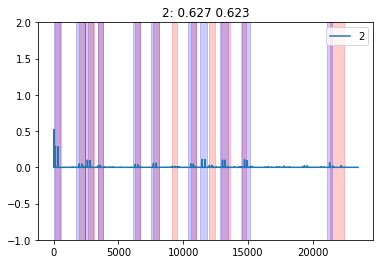

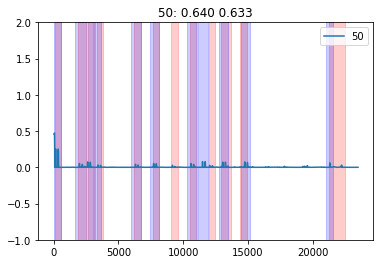

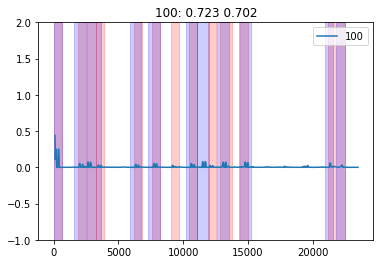

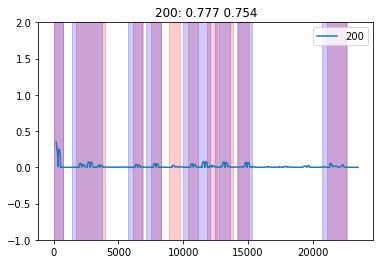

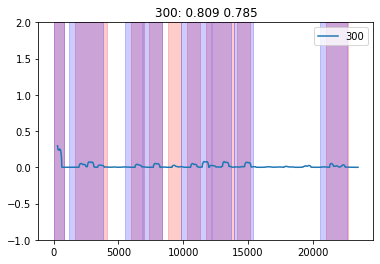

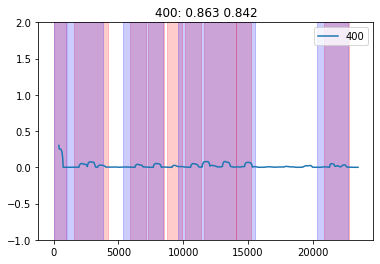

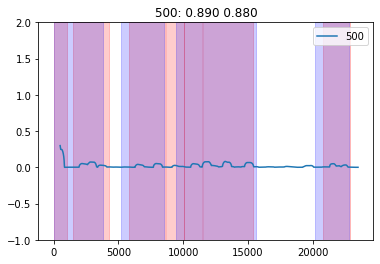

In [86]:
ws_list = [2, 50, 100, 200, 300, 400, 500]
mstdds = {ws: get_diff(get_std(m_3_10_scores['AnomTrans'], ws, na='drop')) for ws in ws_list}
tmp_ranges = get_cls_ids_ranges(pd.Index(range(len(m_3_10_cls))), m_3_10_cls)

model_ws = 200
at_sth_3_10_scores = {}
ths = [0.03] * len(ws_list)

for ws, th in zip(ws_list, ths):
    tmp_m3_10_ws_cls = adjust_point_cls_with_window(m_3_10_cls, ws, return_point_cls=False)
    tmp_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(tmp_m3_10_ws_cls))), tmp_m3_10_ws_cls)
    
    pred_ws_cls = np.array(mstdds[ws] > th, dtype=int).reshape(-1)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, model_ws, return_point_cls=True)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, ws, return_point_cls=True)
    pred_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(pred_ws_cls))), pred_ws_cls)

    f1 = fbeta_score(tmp_m3_10_ws_cls, pred_ws_cls, beta=1)
    f05 = fbeta_score(tmp_m3_10_ws_cls, pred_ws_cls, beta=0.5)
    title = f'{ws}: %.3f %.3f' % (f1, f05)
    at_sth_3_10_scores[ws] = [ws, th, f1, f05]
    
    plot_dataset(
        {ws: mstdds[ws]}, anoms_vrects=tmp_ws_ranges, pred_anoms_vrects=pred_ws_ranges,
        y_lims=(-1, 2), figsize=(6, 4), titles=[title]);

### Comparison

In [87]:
at_3_10_scores_df = pd.DataFrame.from_dict(
    at_3_10_scores, orient='index', columns=['ws','th','f1.0-score','f0.5-score']).reset_index(drop=True)
at_sth_3_10_scores_df = pd.DataFrame.from_dict(
    at_sth_3_10_scores, orient='index', columns=['ws','th','f1.0-score','f0.5-score']).reset_index(drop=True)

at_3_10_scores_df.join(at_sth_3_10_scores_df, lsuffix='_at', rsuffix='_std')

,ws_at,th_at,f1.0-score_at,f0.5-score_at,ws_std,th_std,f1.0-score_std,f0.5-score_std
0,2,0.05,0.751542,0.668004,2,0.03,0.626866,0.622820
1,50,0.05,0.793239,0.716038,50,0.03,0.639688,0.633493
2,100,0.05,0.830170,0.759186,100,0.03,0.723100,0.702027
3,200,0.05,0.860648,0.799207,200,0.03,0.777378,0.753917
4,300,0.05,0.883005,0.829462,300,0.03,0.809489,0.785219
5,400,0.05,0.895912,0.847254,400,0.03,0.863185,0.842111
6,500,0.05,0.923077,0.882716,500,0.03,0.889912,0.880117


# Comparing AnomTrans with Bollinger

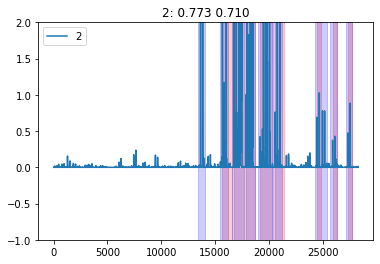

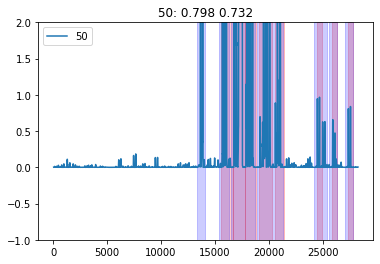

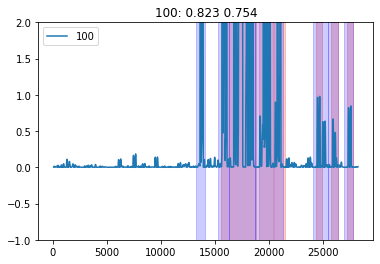

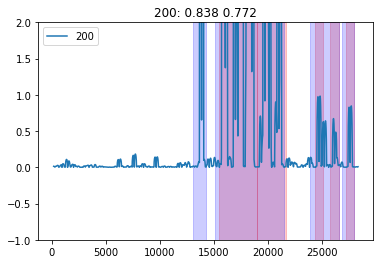

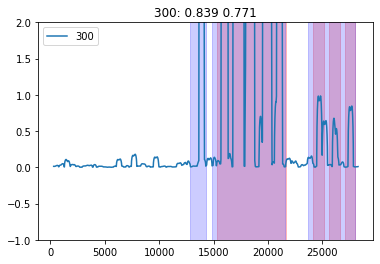

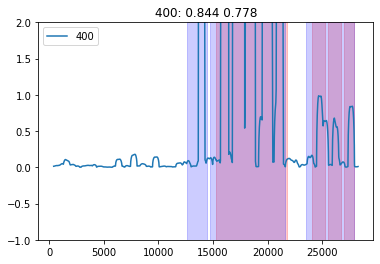

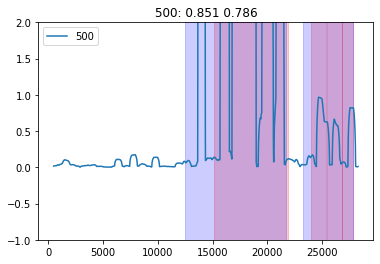

In [ ]:
ws_list = [2, 50, 100, 200, 300, 400, 500]
mstdds = {ws: get_diff(get_std(m_1_1_scores['AnomTrans'], ws, na='drop')) for ws in ws_list}
tmp_ranges = get_cls_ids_ranges(pd.Index(range(len(m_1_1_cls))), m_1_1_cls)

model_ws = 200
at_sth_1_1_scores = {}
ths = [0.3] * len(ws_list)

for ws, th in zip(ws_list, ths):
    tmp_m1_1_ws_cls = adjust_point_cls_with_window(m_1_1_cls, ws, return_point_cls=False)
    tmp_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(tmp_m1_1_ws_cls))), tmp_m1_1_ws_cls)
    
    pred_ws_cls = np.array(mstdds[ws] > th, dtype=int).reshape(-1)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, model_ws, return_point_cls=True)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, ws, return_point_cls=True)
    pred_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(pred_ws_cls))), pred_ws_cls)

    f1 = fbeta_score(tmp_m1_1_ws_cls, pred_ws_cls, beta=1)
    f05 = fbeta_score(tmp_m1_1_ws_cls, pred_ws_cls, beta=0.5)
    title = f'{ws}: %.3f %.3f' % (f1, f05)
    at_sth_1_1_scores[ws] = [ws, th, f1, f05]
    
    plot_dataset(
        {ws: mstdds[ws]}, anoms_vrects=tmp_ws_ranges, pred_anoms_vrects=pred_ws_ranges,
        y_lims=(-1, 2), figsize=(6, 4), titles=[title]);

### Comparison

In [ ]:
at_1_1_scores_df = pd.DataFrame.from_dict(
    at_1_1_scores, orient='index', columns=['ws','th','f1.0-score','f0.5-score']).reset_index(drop=True)
at_sth_1_1_scores_df = pd.DataFrame.from_dict(
    at_sth_1_1_scores, orient='index', columns=['ws','th','f1.0-score','f0.5-score']).reset_index(drop=True)

at_1_1_scores_df.join(at_sth_1_1_scores_df, lsuffix='_at', rsuffix='_std')

,ws_at,th_at,f1.0-score_at,f0.5-score_at,ws_std,th_std,f1.0-score_std,f0.5-score_std
0,2,0.5,0.792853,0.723059,2,0.5,0.773368,0.710359
1,50,0.5,0.825590,0.759504,50,0.5,0.798012,0.731713
2,100,0.5,0.848202,0.788094,100,0.5,0.823031,0.753820
3,200,0.5,0.873919,0.820083,200,0.5,0.838300,0.771866
4,300,0.5,0.885238,0.835413,300,0.5,0.839200,0.771466
5,400,0.5,0.891563,0.844000,400,0.5,0.844014,0.777605
6,500,0.5,0.903489,0.860753,500,0.5,0.850553,0.786170


## Machine 2-1

### AnomTrans a_score

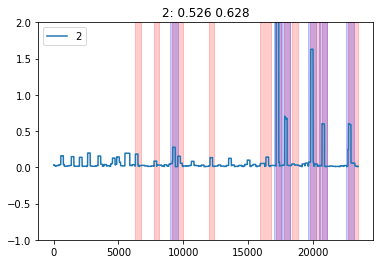

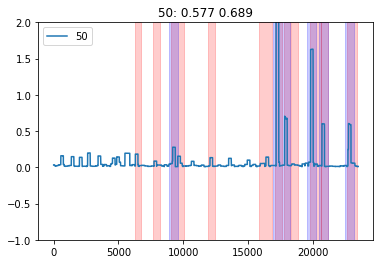

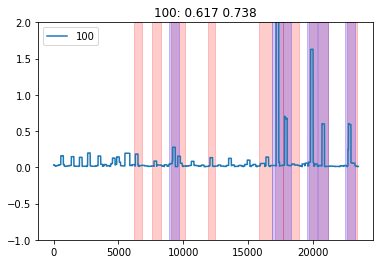

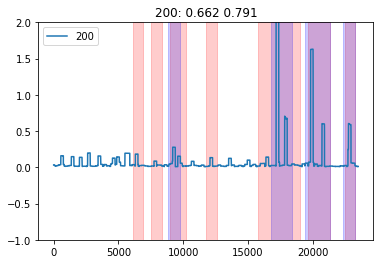

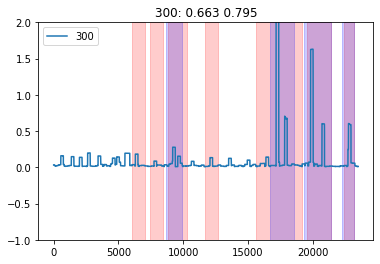

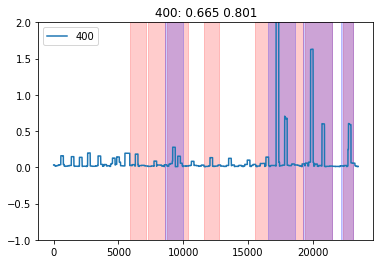

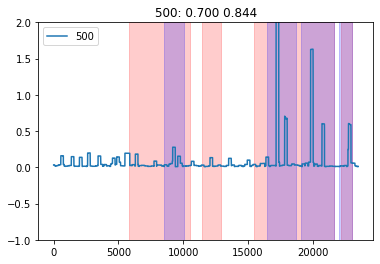

In [ ]:
ws_list = [2, 50, 100, 200, 300, 400, 500]
tmp_ranges = get_cls_ids_ranges(pd.Index(range(len(m_2_1_cls))), m_2_1_cls)

model_ws = 200
at_2_1_scores = {}
th = 0.25

for ws in ws_list:
    tmp_m2_1_ws_cls = adjust_point_cls_with_window(m_2_1_cls, ws, return_point_cls=False)
    tmp_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(tmp_m2_1_ws_cls))), tmp_m2_1_ws_cls)
    
    pred_ws_cls = np.array(m_2_1_scores['AnomTrans'] > th, dtype=int).reshape(-1)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, model_ws, return_point_cls=True)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, ws, return_point_cls=False)
    pred_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(pred_ws_cls))), pred_ws_cls)
    
    f1 = fbeta_score(tmp_m2_1_ws_cls, pred_ws_cls, beta=1)
    f05 = fbeta_score(tmp_m2_1_ws_cls, pred_ws_cls, beta=0.5)
    title = f'{ws}: %.3f %.3f' % (f1, f05)
    at_2_1_scores[ws] = [ws, th, f1, f05]
    
    plot_dataset(
        {ws: m_2_1_scores['AnomTrans']}, anoms_vrects=tmp_ws_ranges, pred_anoms_vrects=pred_ws_ranges,
        y_lims=(-1, 2), figsize=(6, 4), titles=[title]);

### MSTDD

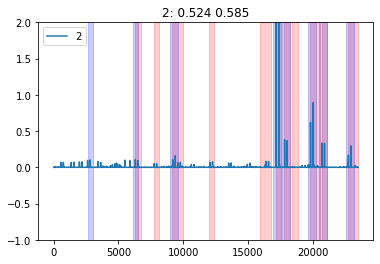

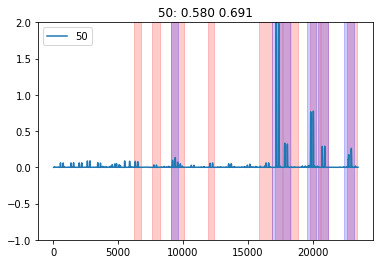

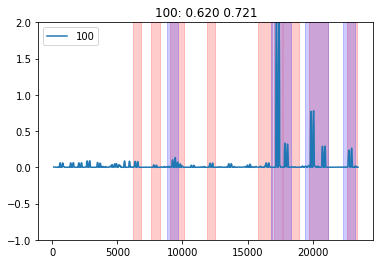

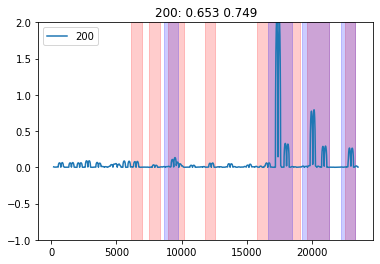

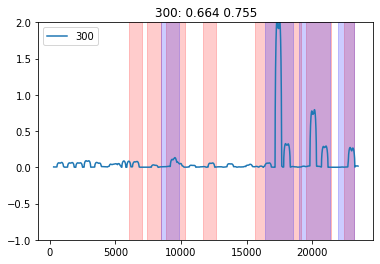

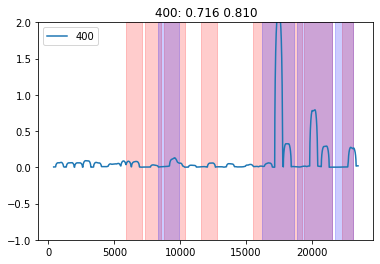

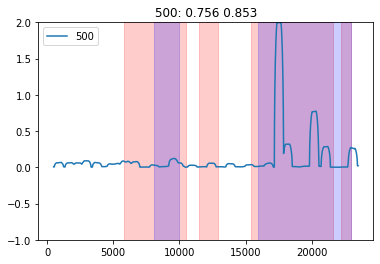

In [ ]:
ws_list = [2, 50, 100, 200, 300, 400, 500]
mstdds = {ws: get_diff(get_std(m_2_1_scores['AnomTrans'], ws, na='drop')) for ws in ws_list}
tmp_ranges = get_cls_ids_ranges(pd.Index(range(len(m_2_1_cls))), m_2_1_cls)

model_ws = 200
at_sth_2_1_scores = {}
ths = [0.1] * len(ws_list)

for ws, th in zip(ws_list, ths):
    tmp_m2_1_ws_cls = adjust_point_cls_with_window(m_2_1_cls, ws, return_point_cls=False)
    tmp_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(tmp_m2_1_ws_cls))), tmp_m2_1_ws_cls)
    
    pred_ws_cls = np.array(mstdds[ws] > th, dtype=int).reshape(-1)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, model_ws, return_point_cls=True)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, ws, return_point_cls=True)
    pred_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(pred_ws_cls))), pred_ws_cls)

    f1 = fbeta_score(tmp_m2_1_ws_cls, pred_ws_cls, beta=1)
    f05 = fbeta_score(tmp_m2_1_ws_cls, pred_ws_cls, beta=0.5)
    title = f'{ws}: %.3f %.3f' % (f1, f05)
    at_sth_2_1_scores[ws] = [ws, th, f1, f05]
    
    plot_dataset(
        {ws: mstdds[ws]}, anoms_vrects=tmp_ws_ranges, pred_anoms_vrects=pred_ws_ranges,
        y_lims=(-1, 2), figsize=(6, 4), titles=[title]);

### Comparison

In [ ]:
at_2_1_scores_df = pd.DataFrame.from_dict(
    at_2_1_scores, orient='index', columns=['ws','th','f1.0-score','f0.5-score']).reset_index(drop=True)
at_sth_2_1_scores_df = pd.DataFrame.from_dict(
    at_sth_2_1_scores, orient='index', columns=['ws','th','f1.0-score','f0.5-score']).reset_index(drop=True)

at_2_1_scores_df.join(at_sth_2_1_scores_df, lsuffix='_at', rsuffix='_std')

,ws_at,th_at,f1.0-score_at,f0.5-score_at,ws_std,th_std,f1.0-score_std,f0.5-score_std
0,2,0.25,0.525996,0.627721,2,0.1,0.523930,0.584902
1,50,0.25,0.576886,0.689430,50,0.1,0.579921,0.690627
2,100,0.25,0.616856,0.737809,100,0.1,0.620402,0.720578
3,200,0.25,0.662351,0.790681,200,0.1,0.652842,0.749312
4,300,0.25,0.662814,0.795071,300,0.1,0.663713,0.755375
5,400,0.25,0.665339,0.801234,400,0.1,0.716324,0.810232
6,500,0.25,0.699601,0.843938,500,0.1,0.756363,0.853157


## Machine 3-10

### AnomTrans a_score

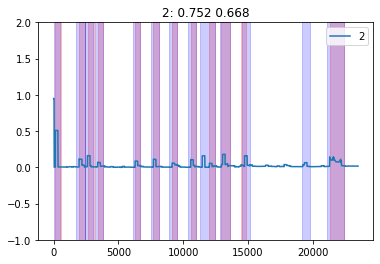

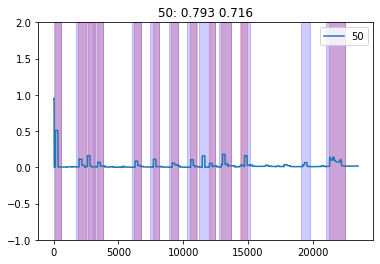

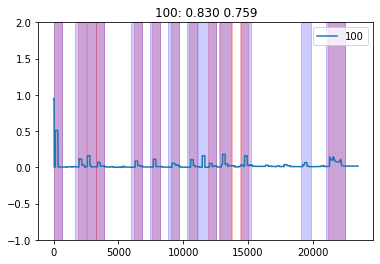

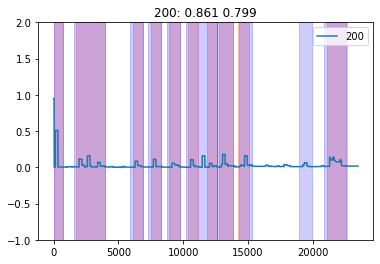

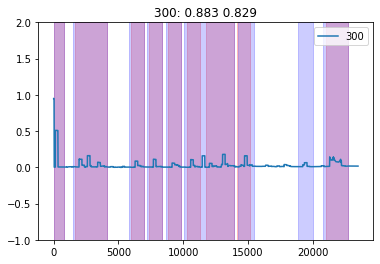

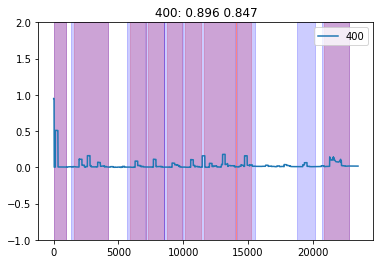

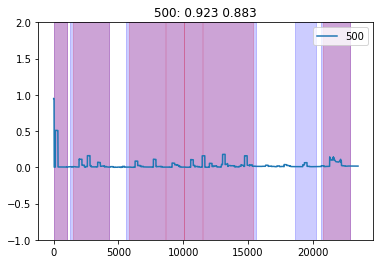

In [ ]:
ws_list = [2, 50, 100, 200, 300, 400, 500]
tmp_ranges = get_cls_ids_ranges(pd.Index(range(len(m_3_10_cls))), m_3_10_cls)

model_ws = 200
at_3_10_scores = {}
th = 0.05

for ws in ws_list:
    tmp_m3_10_ws_cls = adjust_point_cls_with_window(m_3_10_cls, ws, return_point_cls=False)
    tmp_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(tmp_m3_10_ws_cls))), tmp_m3_10_ws_cls)
    
    pred_ws_cls = np.array(m_3_10_scores['AnomTrans'] > th, dtype=int).reshape(-1)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, model_ws, return_point_cls=True)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, ws, return_point_cls=False)
    pred_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(pred_ws_cls))), pred_ws_cls)
    
    f1 = fbeta_score(tmp_m3_10_ws_cls, pred_ws_cls, beta=1)
    f05 = fbeta_score(tmp_m3_10_ws_cls, pred_ws_cls, beta=0.5)
    title = f'{ws}: %.3f %.3f' % (f1, f05)
    at_3_10_scores[ws] = [ws, th, f1, f05]
    
    plot_dataset(
        {ws: m_3_10_scores['AnomTrans']}, anoms_vrects=tmp_ws_ranges, pred_anoms_vrects=pred_ws_ranges,
        y_lims=(-1, 2), figsize=(6, 4), titles=[title]);

### MSTDD

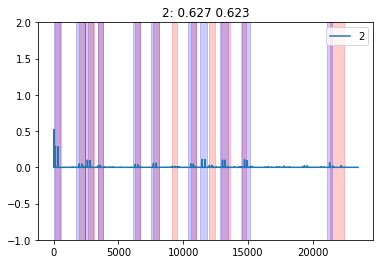

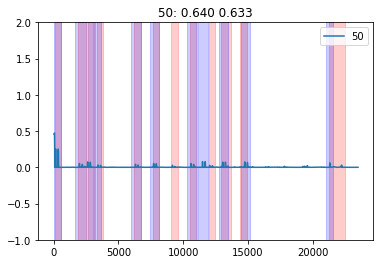

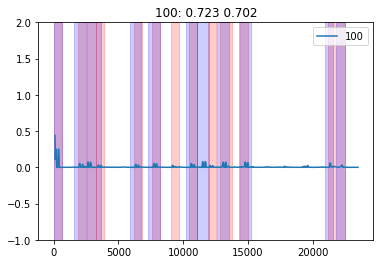

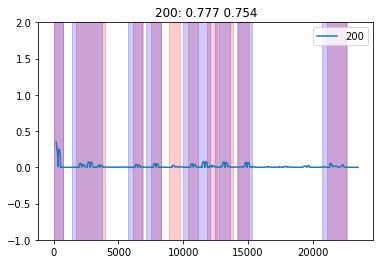

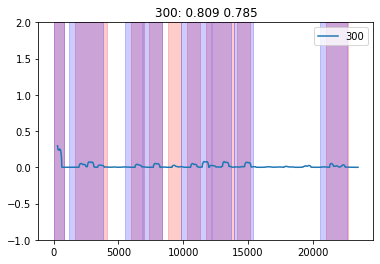

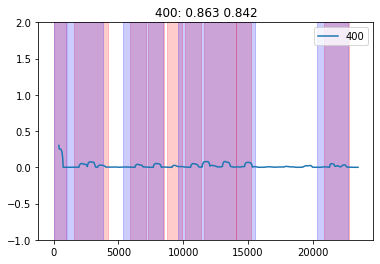

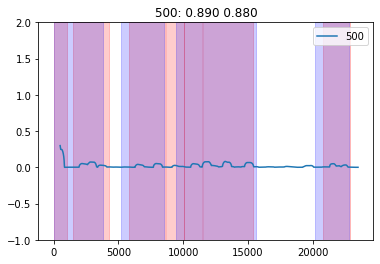

In [ ]:
ws_list = [2, 50, 100, 200, 300, 400, 500]
mstdds = {ws: get_diff(get_std(m_3_10_scores['AnomTrans'], ws, na='drop')) for ws in ws_list}
tmp_ranges = get_cls_ids_ranges(pd.Index(range(len(m_3_10_cls))), m_3_10_cls)

model_ws = 200
at_sth_3_10_scores = {}
ths = [0.03] * len(ws_list)

for ws, th in zip(ws_list, ths):
    tmp_m3_10_ws_cls = adjust_point_cls_with_window(m_3_10_cls, ws, return_point_cls=False)
    tmp_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(tmp_m3_10_ws_cls))), tmp_m3_10_ws_cls)
    
    pred_ws_cls = np.array(mstdds[ws] > th, dtype=int).reshape(-1)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, model_ws, return_point_cls=True)
    pred_ws_cls = adjust_point_cls_with_window(pred_ws_cls, ws, return_point_cls=True)
    pred_ws_ranges = get_cls_ids_ranges(pd.Index(range(len(pred_ws_cls))), pred_ws_cls)

    f1 = fbeta_score(tmp_m3_10_ws_cls, pred_ws_cls, beta=1)
    f05 = fbeta_score(tmp_m3_10_ws_cls, pred_ws_cls, beta=0.5)
    title = f'{ws}: %.3f %.3f' % (f1, f05)
    at_sth_3_10_scores[ws] = [ws, th, f1, f05]
    
    plot_dataset(
        {ws: mstdds[ws]}, anoms_vrects=tmp_ws_ranges, pred_anoms_vrects=pred_ws_ranges,
        y_lims=(-1, 2), figsize=(6, 4), titles=[title]);

### Comparison

In [ ]:
at_3_10_scores_df = pd.DataFrame.from_dict(
    at_3_10_scores, orient='index', columns=['ws','th','f1.0-score','f0.5-score']).reset_index(drop=True)
at_sth_3_10_scores_df = pd.DataFrame.from_dict(
    at_sth_3_10_scores, orient='index', columns=['ws','th','f1.0-score','f0.5-score']).reset_index(drop=True)

at_3_10_scores_df.join(at_sth_3_10_scores_df, lsuffix='_at', rsuffix='_std')

,ws_at,th_at,f1.0-score_at,f0.5-score_at,ws_std,th_std,f1.0-score_std,f0.5-score_std
0,2,0.05,0.751542,0.668004,2,0.03,0.626866,0.622820
1,50,0.05,0.793239,0.716038,50,0.03,0.639688,0.633493
2,100,0.05,0.830170,0.759186,100,0.03,0.723100,0.702027
3,200,0.05,0.860648,0.799207,200,0.03,0.777378,0.753917
4,300,0.05,0.883005,0.829462,300,0.03,0.809489,0.785219
5,400,0.05,0.895912,0.847254,400,0.03,0.863185,0.842111
6,500,0.05,0.923077,0.882716,500,0.03,0.889912,0.880117


# Rest

G-mean scores thresholding

In [92]:
# mstdd = get_diff(get_std(m_1_1_scores['AnomTrans'], 200, na='drop')).to_numpy()
# ws_true_cls = adjust_point_cls_with_window(
#     m_1_1_cls, 200, return_point_cls=False
# )
# fpr, tpr, ths = roc_curve(ws_true_cls, mstdd)
# g_means = np.sqrt(tpr*(1-fpr))

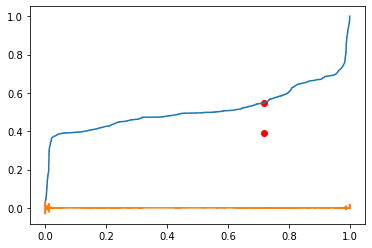

In [93]:
tmp_stat = pd.Series(tpr).diff().diff().fillna(0).to_numpy() 
# id_max = g_means.argmax()


plt.plot(fpr, tpr);
plt.plot(fpr, tmp_stat);
plt.scatter([fpr[id_max], fpr[id_max]], [tpr[id_max], g_means[id_max]], c='r')

In [117]:
best_sth = calculate_mstdd_scores(m_1_1_scores, m_1_1_point_cls, model_ws=200, ths=[0.25] * 6)

In [119]:
best_sth

,ws,th,f1.0-score,f0.5-score
0,50,0.25,0.731463,0.774616
1,50,0.25,0.731463,0.774616
2,100,0.25,0.719241,0.767647
3,100,0.25,0.719241,0.767647
4,200,0.25,0.624028,0.699452
5,200,0.25,0.624028,0.699452
6,300,0.25,0.368473,0.488001
7,300,0.25,0.368473,0.488001
8,400,0.25,0.373147,0.483193
9,400,0.25,0.373147,0.483193


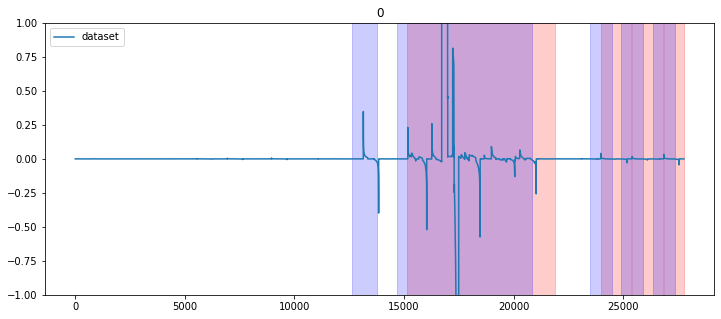

In [289]:
plot_dataset(
    mstdd, anoms_vrects=get_cls_ids_ranges(
        pd.Index(range(len(ws_true_cls))), ws_true_cls),
    pred_anoms_vrects=get_cls_ids_ranges(
        pd.Index(range(len(ws_pred_cls))), ws_pred_cls),
    y_lims=(-1, 1), figsize=(12, 5));

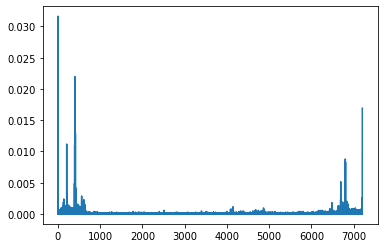

In [253]:
sns.lineplot(x=range(len(tpr)), y=pd.Series(tpr).diff().fillna(0).to_list());

In [277]:
ths[300]

0.012969102183102876

In [298]:
g_mean = np.sqrt(tpr * (1-fpr))
g_mean[g_mean.argmax()], g_mean.argmax()

(0.6066436520690817, 1000)

KeyboardInterrupt: 

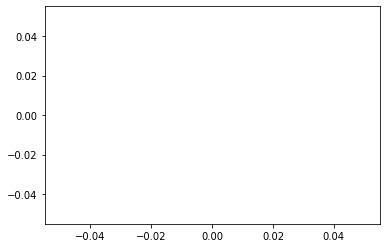

In [300]:
fpr, tpr, ths = roc_curve(ws_true_cls, mstdd)
sns.lineplot(x=fpr, y=tpr);

In [180]:
mstdd_scores = calculate_mstdd_scores(m_1_1_scores['AnomTrans'], m_1_1_cls)
# adjust_point_cls_with_window(
#     m_1_1_cls, 100, return_point_cls=False
# ).shape
# get_diff(get_std(m_1_1_scores['AnomTrans'], 100, na='drop'))

In [151]:
lr_predict(m_1_1_scores['AnomTrans'], m_1_1_cls)

array([0., 0., 0., ..., 0., 0., 0.])

In [142]:
def get_ws_scores(
    true_cls: np.ndarray, pred_cls: np.ndarray,
    ws_list: List[int] = [50, 100, 200, 300, 400, 500]
):
    res = {}
    for ws in ws_list:
        ws_true_cls = adjust_point_cls_with_window(true_cls, ws, return_point_cls=False)
        ws_pred_cls = adjust_point_cls_with_window(pred_cls, ws, return_point_cls=False)
        res[ws] = [
            fbeta_score(ws_true_cls, ws_pred_cls, beta=1),
            fbeta_score(ws_true_cls, ws_pred_cls, beta=0.5)
        ]
    res = pd.DataFrame.from_dict(res, orient='index')
    return res

In [152]:
m_1_1_at_ws_scores = get_ws_scores(
    m_1_1_cls,
    lr_predict(
        m_1_1_scores['AnomTrans'],
        m_1_1_cls))

In [153]:
m_1_1_at_ws_scores

,0,1
50,0.746832,0.789055
100,0.757335,0.804710
200,0.747634,0.795850
300,0.734286,0.782582
400,0.716731,0.766028
500,0.699899,0.750410


In [120]:
m_1_1_at_sth_scores = load_best_ws_sth('machine-1-1', 'AnomTrans_l2_d128_lambda3', '2022-06-16_01:36:24')

In [121]:
m_1_1_at_sth_scores

,ws,th,wdd,f1.0-score,f0.5-score,tn,fp,fn,tp,preds_rec_cls
691,50,0.013835,NaN,0.619801,0.640401,19504,2065,2743,3919,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1968,100,0.019380,NaN,0.748022,0.744130,18845,1944,1814,5578,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2986,200,0.019740,NaN,0.849983,0.844959,18215,1372,1202,7292,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3496,300,0.009932,NaN,0.892429,0.890847,17690,1027,972,8292,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4401,400,0.008031,NaN,0.887988,0.894823,17050,967,1215,8649,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5353,500,0.007070,NaN,0.883496,0.884410,16118,1199,1235,9229,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
